In [29]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random

import simpy

# Set Parameters

In [223]:
INTERVAL_CUSTOMERS=5 # average time between events
PROCESSING_TIME=4  # average processing time in the bank
CUSTOMERS=10 # number of customers 

# Prepare Random Data

In [224]:
random.seed(42)

In [225]:
# Create a DataFrame with input parameters
x = pd.DataFrame()
x['arr'] = [ random.expovariate(1.0/INTERVAL_CUSTOMERS) for i in range(CUSTOMERS) ]
x['proc'] = [ random.expovariate(1.0/PROCESSING_TIME) for i in range(CUSTOMERS) ]

In [226]:
x.head()

,arr,proc
0,5.100301,0.986867
1,0.126644,2.815662
2,1.608120,0.107578
3,1.262931,0.886767
4,6.667963,4.197968


In [227]:
x.describe()

,arr,proc
count,10.000000,10.000000
mean,3.489451,2.335653
std,3.598516,2.116568
min,0.126644,0.026080
25%,0.656804,0.911792
50%,2.174176,1.905884
75%,5.509474,3.456755
max,11.136440,6.630952


In [228]:
def poissonPlot(data, title=None):
    μ = data.mean()
    n = data.count()
    max = math.ceil(data.max()/10)*10
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax = fig.gca()
    ax.set_xlim(0, max)
    
    if title!=None:
        ax.set_title(title+" (n={:,})".format(n))
        
    data.hist(ax=ax, bins=max+1, density=True)

    x = [ i/10 for i in range(1, 10*max)]
    y = [ 1/μ*math.exp(-x/μ) for x in x]
    plt.plot(x, y, lw=3, color='red')
    ax.axvline(x=μ, color='red')
    plt.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=14)
    plt.grid(True)
    plt.show(block=False)

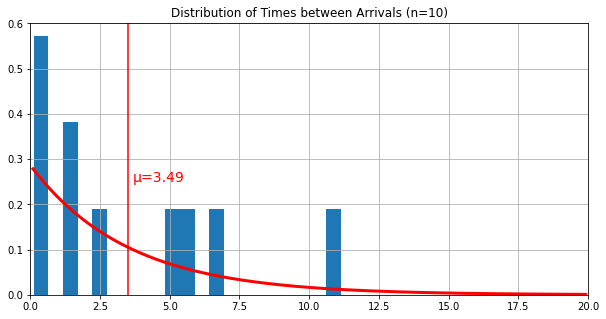

In [229]:
poissonPlot(x['arr'], title="Distribution of Times between Arrivals")

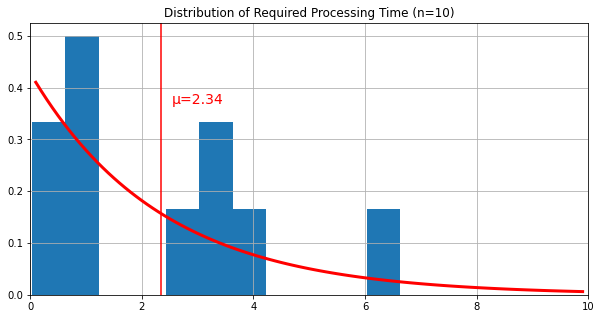

In [230]:
poissonPlot(x['proc'], title="Distribution of Required Processing Time")

# Prepare DataFrame to Record Simulation Results

In [231]:
# Prepare a DataFrame to record observations
y = pd.DataFrame()
y['arrived at'] = [None]*CUSTOMERS
y['proc started at'] = [None]*CUSTOMERS
y['proc finished at'] = [None]*CUSTOMERS 

In [232]:
y.head()

,arrived at,proc started at,proc finished at
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None


# Run Simulation

In [233]:
def generatorProcess(env, n, server):
    for i in range(n):
        t = x.at[i, 'arr']
        # wait until the next customer arrives...
        yield env.timeout(t)
        env.process(customerProcess(env, i, server))

In [234]:
def customerProcess(env, i, server):
    y.at[i, 'arrived at'] = env.now
    print(f"customer {i:d} arrives at  {env.now:6.2f}")
    
    req = server.request()
        
    # Wait for the server 
    yield req 

    print(f"serving customer {i:d} at  {env.now:6.2f}")
    y.at[i, 'proc started at'] = env.now
    
    yield env.timeout(x.at[i, 'proc'])
    
    y.at[i, 'proc finished at'] = env.now
    print(f"finished customer {i:d} at {env.now:6.2f}")
    
    server.release(req)

In [235]:
len(x)

10

In [236]:
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)
env.process(generatorProcess(env, CUSTOMERS, server))
env.run()

customer 0 arrives at    5.10
serving customer 0 at    5.10
customer 1 arrives at    5.23
finished customer 0 at   6.09
serving customer 1 at    6.09
customer 2 arrives at    6.84
customer 3 arrives at    8.10
finished customer 1 at   8.90
serving customer 2 at    8.90
finished customer 2 at   9.01
serving customer 3 at    9.01
finished customer 3 at   9.90
customer 4 arrives at   14.77
serving customer 4 at   14.77
finished customer 4 at  18.96
customer 5 arrives at   20.41
serving customer 5 at   20.41
finished customer 5 at  23.56
customer 6 arrives at   31.55
serving customer 6 at   31.55
customer 7 arrives at   32.00
finished customer 6 at  32.54
serving customer 7 at   32.54
customer 8 arrives at   34.74
customer 9 arrives at   34.89
finished customer 7 at  36.10
serving customer 8 at   36.10
finished customer 8 at  42.73
serving customer 9 at   42.73
finished customer 9 at  42.76


In [237]:
y.head(10)

,arrived at,proc started at,proc finished at
0,5.1003,5.1003,6.08717
1,5.22695,6.08717,8.90283
2,6.83507,8.90283,9.01041
3,8.098,9.01041,9.89717
4,14.766,14.766,18.9639
5,20.4118,20.4118,23.5611
6,31.5483,31.5483,32.5444
7,32.003,32.5444,36.1036
8,34.7433,36.1036,42.7346
9,34.8945,42.7346,42.7606


# Fill-In Derived Data

In [238]:
y['wait time']=y['proc started at']-y['arrived at'] 
y['proc time']=y['proc finished at']-y['proc started at']
y['idle time']=y['proc started at']-y['proc finished at'].shift(1)
y.at[0, 'idle time']=y.at[0, 'proc started at']

In [239]:
y.head(10)

,arrived at,proc started at,proc finished at,wait time,proc time,idle time
0,5.1003,5.1003,6.08717,0,0.986867,5.1003
1,5.22695,6.08717,8.90283,0.860223,2.81566,0
2,6.83507,8.90283,9.01041,2.06776,0.107578,0
3,8.098,9.01041,9.89717,0.912411,0.886767,0
4,14.766,14.766,18.9639,0,4.19797,4.86879
5,20.4118,20.4118,23.5611,0,3.14932,1.4479
6,31.5483,31.5483,32.5444,0,0.996106,7.98712
7,32.003,32.5444,36.1036,0.541344,3.55923,0
8,34.7433,36.1036,42.7346,1.36035,6.63095,0
9,34.8945,42.7346,42.7606,7.84005,0.0260799,0


# Analyse Results of this Simulation Run

In [240]:
w = y['wait time']
print(f"Customers waited in average  {w.mean():5.2f}min.")
print(f"The minimum waiting time was {w.min():5.2f}min.")
print(f"the maximum waiting time was {w.max():5.2f}min.")

Customers waited in average   1.36min.
The minimum waiting time was  0.00min.
the maximum waiting time was  7.84min.


In [241]:
proc_time=y['proc time'].sum()
idle_time=y['idle time'].sum()
total_time=proc_time+idle_time
print(f"Server utilisation was {100*proc_time/total_time:4.1f}% "
      f"over a total time of {total_time/60:4.1f} hours")

Server utilisation was 54.6% over a total time of  0.7 hours


# Run Simulation Study

In [242]:
def MM1(IARR, PROC, N, log=False, plot=False):   # tOT CE AM FACUT SUS AM PUS INTRUN SCRIPT aici
    
    # Prepare a DataFrame with input parameters
    x = pd.DataFrame()
    x['iarr'] = [ random.expovariate(1.0/IARR) for i in range(N) ]
    x['proc'] = [ random.expovariate(1.0/PROC) for i in range(N) ]
    
    # Prepare a DataFrame to record observations
    y = pd.DataFrame()
    y['arrived at'] = [None]*N
    y['proc started at'] = [None]*N
    y['proc finished at'] = [None]*N 
    
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    
    # initialise variables describing the queue
    maxql=0  # maximum length of queue
    qt=0     # "integral" of ql from 0 to lastT
    lastT=0 # last time qt was updated
    
    # initialise variables describing the server
    maxs=0   # max number of customers served at anyone time
    s=0      # current number of customers being served
    st=0     # "integral" of s from 0 to env.now
    
    def generatorProcess(n):
        # generate the customers.
        for i in range(n):
            # wait until the next customer arrives...
            yield env.timeout(x.at[i, 'iarr'])
            env.process(customerProcess(i))
     
    def customerProcess(i):
        y.at[i, 'arrived at'] = env.now
        
        nonlocal qt, lastT, maxql, s, st, maxs
        
        # length of the queue before the customer enters

        ql = len(server.queue) 
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        if ql==maxql:
            maxql = ql+1

        req = server.request()
        # Wait for the server 
        
        yield req
        
        # length of the queue just before the customer leaves
        ql = len(server.queue)+1 
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        y.at[i, 'proc started at'] = env.now
        # Wait while the clerk is dealing with you
        
        s += 1
        if s>maxs:
            maxs = s
            
        proc = x.at[i, 'proc']
        yield env.timeout(proc)
        y.at[i, 'proc finished at'] = env.now
        server.release(req)
        
        s -= 1
        st += proc
        
            
    env.process(generatorProcess(N))
    env.run()
    
    y['wait time']=y['proc started at']-y['arrived at'] 
    y['proc time']=y['proc finished at']-y['proc started at']
    y['flow time']=y['proc finished at']-y['arrived at']
    
    y['idle time']=y['proc started at']-y['proc finished at'].shift(1)
    y.at[0, 'idle time']=y.at[0, 'proc started at']
    
    y['idep']=y['proc finished at']-y['proc finished at'].shift(1)
    y.at[0, 'idep']=y.at[0, 'proc finished at']
    
    w = y['wait time']
    f = y['flow time']
    
    if plot:
        poissonPlot(x['iarr'], "Inter-Arrival Times")
        poissonPlot(x['proc'], "Processing Times")
        poissonPlot(y['wait time'], "Wait Times")
        poissonPlot(y['wait time'][y['wait time']>0], "Non-Zero Wait Times")
        poissonPlot(y['flow time'], "Flow Times")
        poissonPlot(y['idep'], "Inter-Departure Times")
        
        
    if log:
        μ_iarr = x['iarr'].mean()
        μ_proc = x['proc'].mean()
        ρ = st/lastT
        ρ_theor = PROC/IARR
        Lq = qt/lastT
  
        print("   actual / expected")
        print(f"a= {μ_iarr:6.2f}   {IARR:6.2f}   (Inter Arrival Time)")
        print(f"p= {μ_proc:6.2f}   {PROC:6.2f}   (Processing Time)")
        print(f"ρ= {100*ρ:5.1f}%  {100*ρ_theor:6.1f}%   (System Utilisation)")
        print(f"L= {ρ+Lq:6.2f}   {ρ_theor/(1-ρ_theor):6.2f}   (inventory in the system)")
        print(f"Lq={Lq:6.2f}   {ρ_theor**2/(1-ρ_theor):6.2f}   (inventory in the queue)")
        print(f"Ls={ρ:6.2f}   {ρ_theor:6.2f}   (inventory in service)")
        print(f"W= {f.mean():6.2f}   {PROC/(1-ρ_theor):6.2f}   (Flow Time through the System")
        print(f"Wq={w.mean():6.2f}   {PROC*ρ_theor/(1-ρ_theor):6.2f}   (Wait Time)")
        print(f"Ws={μ_proc:6.2f}   {PROC:6.2f}   (Service Time)")
        print()
        
    return w.mean(), w.max(), qt/lastT, maxql, st/lastT

In [243]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(5,4,10, log=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   3.49     5.00   (Inter Arrival Time)
p=   2.34     4.00   (Processing Time)
ρ=  54.7%    80.0%   (System Utilisation)
L=   0.86     4.00   (inventory in the system)
Lq=  0.32     3.20   (inventory in the queue)
Ls=  0.55     0.80   (inventory in service)
W=   3.69    20.00   (Flow Time through the System
Wq=  1.36    16.00   (Wait Time)
Ws=  2.34     4.00   (Service Time)

Max Wq=  7.84  
Max Lq=  2  


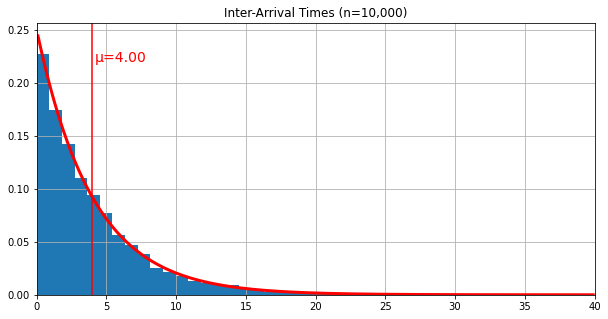

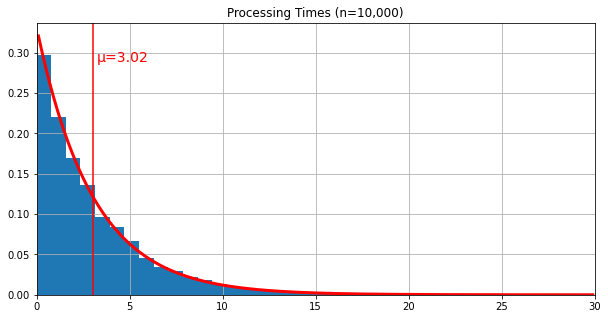

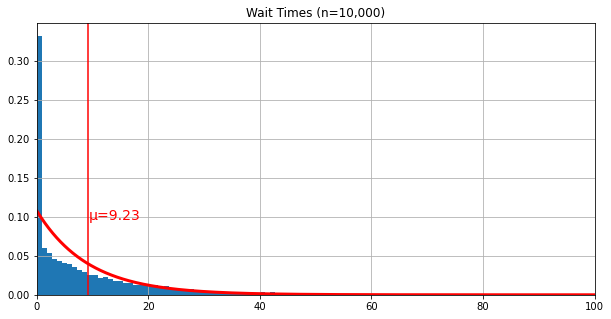

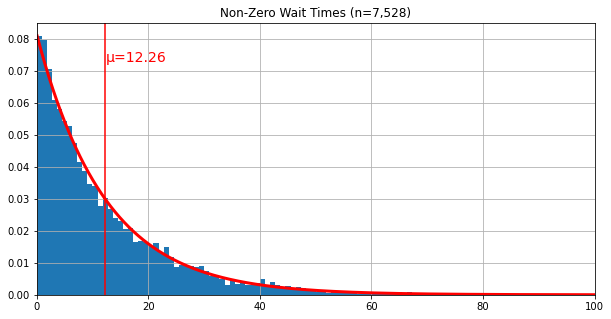

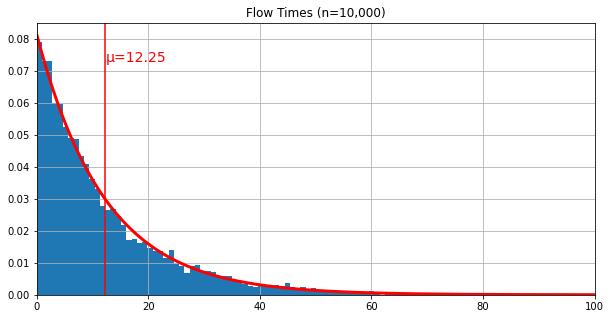

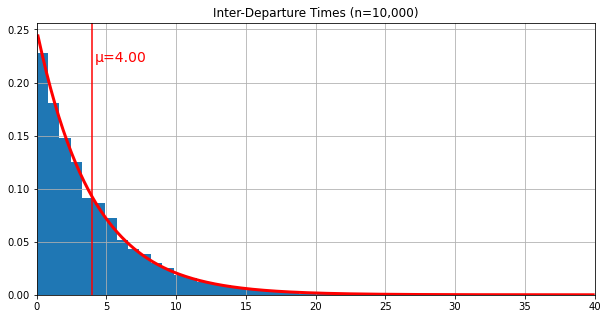

   actual / expected
a=   4.00     4.00   (Inter Arrival Time)
p=   3.02     3.00   (Processing Time)
ρ=  75.5%    75.0%   (System Utilisation)
L=   3.06     3.00   (inventory in the system)
Lq=  2.31     2.25   (inventory in the queue)
Ls=  0.75     0.75   (inventory in service)
W=  12.25    12.00   (Flow Time through the System
Wq=  9.23     9.00   (Wait Time)
Ws=  3.02     3.00   (Service Time)

Max Wq= 91.94  
Max Lq= 23  


In [244]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,10000, log=True, plot=True)                #pot schimba 10000 to 1000-10000e customers
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

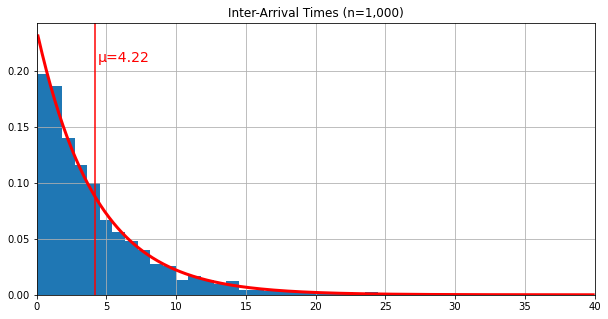

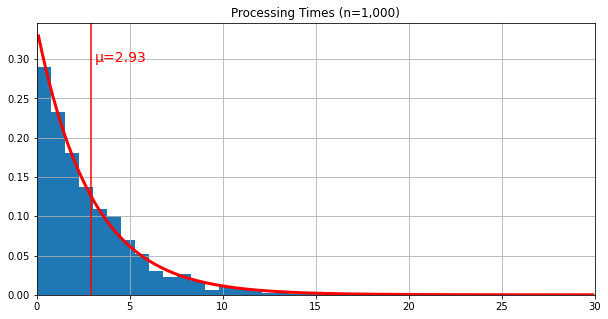

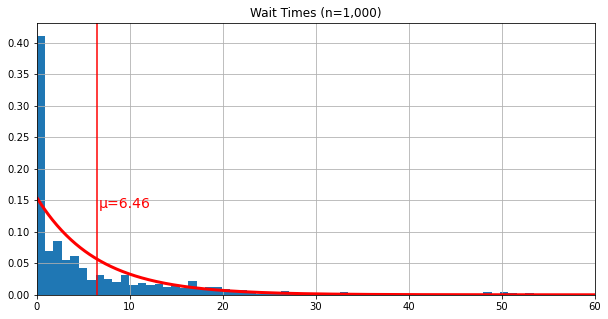

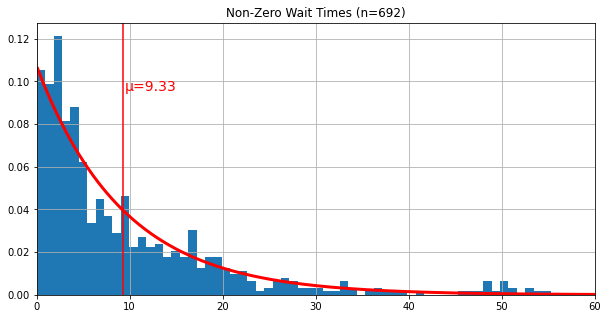

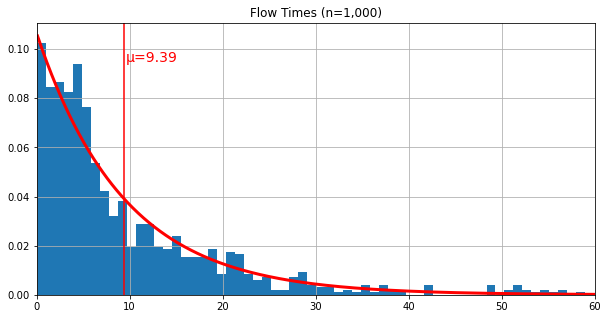

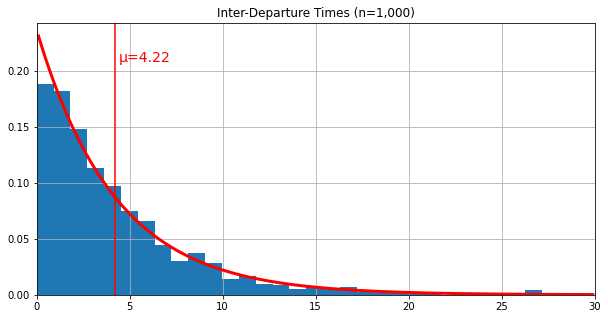

   actual / expected
a=   4.22     4.00   (Inter Arrival Time)
p=   2.93     3.00   (Processing Time)
ρ=  69.5%    75.0%   (System Utilisation)
L=   2.22     3.00   (inventory in the system)
Lq=  1.53     2.25   (inventory in the queue)
Ls=  0.69     0.75   (inventory in service)
W=   9.39    12.00   (Flow Time through the System
Wq=  6.46     9.00   (Wait Time)
Ws=  2.93     3.00   (Service Time)

Max Wq= 55.26  
Max Lq= 18  


In [245]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,1000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

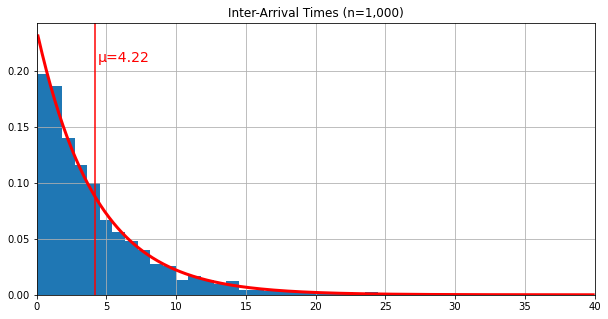

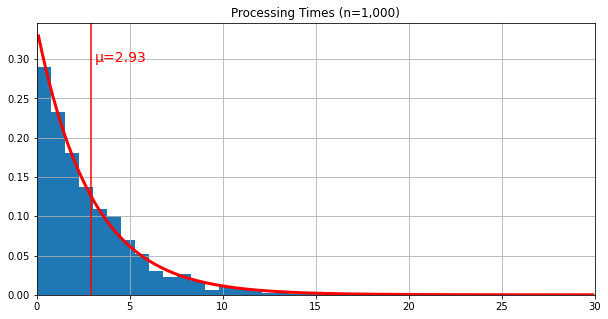

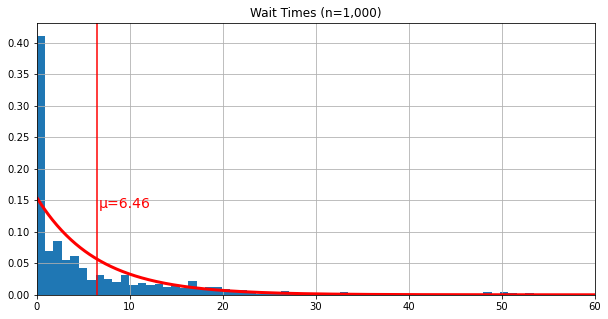

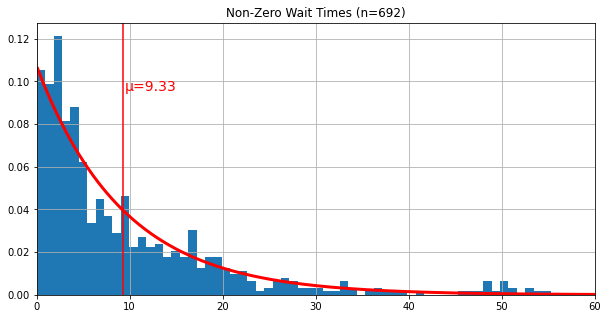

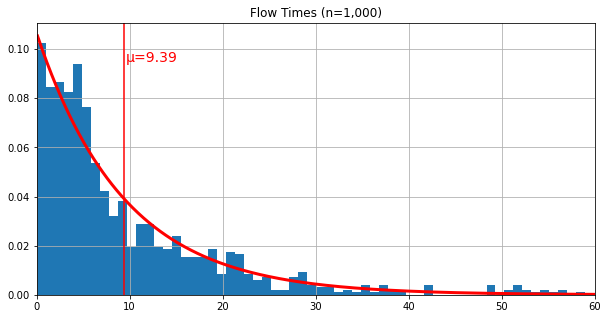

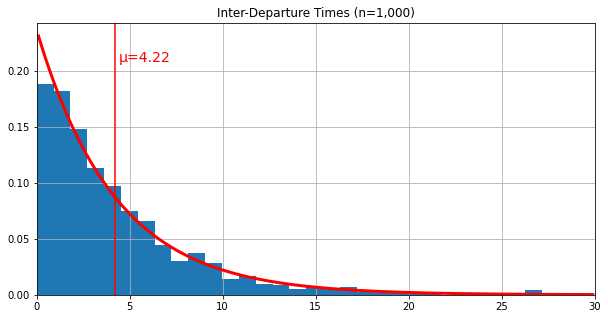

   actual / expected
a=   4.22     4.00   (Inter Arrival Time)
p=   2.93     3.00   (Processing Time)
ρ=  69.5%    75.0%   (System Utilisation)
L=   2.22     3.00   (inventory in the system)
Lq=  1.53     2.25   (inventory in the queue)
Ls=  0.69     0.75   (inventory in service)
W=   9.39    12.00   (Flow Time through the System
Wq=  6.46     9.00   (Wait Time)
Ws=  2.93     3.00   (Service Time)

Max Wq= 55.26  
Max Lq= 18  


In [246]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,1000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

In [30]:
ε = 0.00001

def isZero(x):
    return abs(x)<ε

# Entities

In [31]:
# Time tolerance: when at current speed difference a crash might occur within that number of seconds
CRITICAL_TIME_TOLERANCE = 4  # [s] 
LANE_CHANGE_TIME = 3 # [s]
MIN_TIME_DIFF = 1

MIN_SPEED_DIFF = 2 # [m/s] min speed diff to trigger overtaking

CAR_LENGTH = 4 # [m]

FAR_AWAY_IN_FRONT = 200 # [m]  distance at which a car in front can be ignored
FAR_AWAY_IN_BACK = 80   # [m]  distance at which a car behind can be ignored

# Lanes

The class Lane describes a segment of a lane. It has the width allowing only one vehicle at a point in the lane. i.e. there is no overtaking. Lane segments will be concatenated to form long stretches of road, and will be attached sidewise to each other to form multi lane infrastructure.

Lanes have a state consisting of the vehicles that are at a particular point in time on the lane segment.

In [32]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [33]:
LANE_ID = 0

class Lane:
    
    ## some additional code
    def __init__(self, length, speedLimit):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
        
        self.length = length
        self.speedLimit = speedLimit
        self.vehicles = []
        
        self.next = None
        self.prev = None
        
        # lane attached to the left/right
        self.left = None
        self.right = None
      
    # defines generic str() method for Lanes
    # extends the method with list of vehicles on the lane
    def __str__(self):
        l = "" if self.left is None else f" L:{self.left.id:d}"
        r = "" if self.right is None else f" R:{self.right.id:d}"
        vs = "" if len(self.vehicles)==0 else " "
        for v in self.vehicles:
            vs += str(v)
        return f"[{self.id:d} {int(self.length):d}m"+l+r+vs+"]" + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
     
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
        
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.prev = l
        return self
    
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    ## additional code
    ## new generalised access method needed to calculate sideway view
    ## returns all vehicles between pos+distFrom and pos+distTo
    def at(self, pos, distFrom=-CAR_LENGTH/2, distTo=CAR_LENGTH/2):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if pos+distFrom < v.pos and v.pos < pos+distTo:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if pos+distTo > self.length and self.next is not None:
            res = res + self.next.at(0, distFrom=0, distTo=distTo-(self.length-pos))
        if pos+distFrom < 0 and self.prev is not None:
            res = self.prev.at(self.prev.length, distFrom=pos+distFrom, distTo=0) + res
        return res
        
    def inFront(self, pos, far=FAR_AWAY_IN_FRONT):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far=far-(self.length-pos))
        
    def behind(self, pos, far=FAR_AWAY_IN_BACK):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far=far-pos)
        
    def enter(self, vehicle, pos=0):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane")

    def leave(self, vehicle):
        vehicle.rec.record(vehicle, event="leave lane")
        vehicle.lane = None
        # in the meantime the vehicle may have have moved
        # to one of the next lane segments...
        lane = self
        while lane is not None:
            if vehicle in lane.vehicles:
                lane.vehicles.remove(vehicle)
                break
            else:
                lane = lane.next

In [34]:
#Test the construction of a multilane motorway
VMAX = 120/3.6
LANE_ID = 0
l = Lane(1000, VMAX)
l.extend(Lane(1500, VMAX))
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 1000m R:2]-[1 1500m R:3]
Right Lane: [2 1000m L:0]-[3 1500m L:1]


In [35]:
LANE_ID = 0
l = Lane(1000, VMAX)
while l.totalLength()<5000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()
print("Left Lane: ", l)
print("Right Lane:", r)

Left Lane:  [0 1000m R:5]-[1 1000m R:6]-[2 1000m R:7]-[3 1000m R:8]-[4 1000m R:9]
Right Lane: [5 1000m L:0]-[6 1000m L:1]-[7 1000m L:2]-[8 1000m L:3]-[9 1000m L:4]


In [36]:
LANE_ID = 0
c = Lane(1000, VMAX)
while c.totalLength()<5000:
    c.extend(Lane(1000, VMAX))
l = c.widenLeft()
r = c.widenRight()
print("Left Lane:  ", l)
print("Centre Lane:", c)
print("Right Lane: ", r)

Left Lane:   [5 1000m R:0]-[6 1000m R:1]-[7 1000m R:2]-[8 1000m R:3]-[9 1000m R:4]
Centre Lane: [0 1000m L:5 R:10]-[1 1000m L:6 R:11]-[2 1000m L:7 R:12]-[3 1000m L:8 R:13]-[4 1000m L:9 R:14]
Right Lane:  [10 1000m L:0]-[11 1000m L:1]-[12 1000m L:2]-[13 1000m L:3]-[14 1000m L:4]


# Vehicles

In [46]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [47]:
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, env, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[]):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        self.a_min = -4 # [m/s²]
        self.a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
        
        self.env = env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        ## second lane reference during changing of lanes
        self.oldLane = None
            
        self.t0 = t0
        self.x0 = x0
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0
        
        self.t = t
        self.v = v
        self.t_target = []
        self.v_target = []
        
        self.running = False
        self.crashed = False
        self.braking = False
        self.changingLane = False
        
        self.processRef = None
        self.env.process(self.process())
        
        ## this allows to trigger trace messages for
        ## the new feature Surround
        self.traceSurround = False
        self.traceOvertake = False
        self.traceBrake = False
    
    def __str__(self):
        return f"({self.id:d})"         
    
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    def updateOnly(self):
        if self.crashed:
            return False
        t = self.env.now
        if t < self.t0:
            return False
        if self.running and t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = round(self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2,4)
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
        return True
        
    def update(self):
        active = self.updateOnly()
        if not active:
            return False
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        if (isRunning(inFront) or isCrashed(inFront)) \
               and inFront.x0 < self.x0 + CAR_LENGTH:
            self.crash(inFront)
            return True

        if inFront is not None and not self.braking and \
                self.dx0 > inFront.dx0 and \
                self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0 > inFront.x0:
            Δt = max(MIN_TIME_DIFF, (inFront.x0-self.x0)/self.dx0)
            self.setTarget(Δt, inFront.dx0)
            self.interruptProcess()
            return True
        
        ## new code: start overtaking maneuver by changing into fast lane
        if inFront is not None and \
                not self.braking and not self.changingLane and \
                self.dx0 > inFront.dx0 + MIN_SPEED_DIFF and \
                self.x0 + (LANE_CHANGE_TIME+CRITICAL_TIME_TOLERANCE)*self.dx0 > inFront.x0 and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} overtakes v{inFront.id:d} at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'fast')
            self.interruptProcess()
            return True
            
        ## new code: end overtaking by returning to slow lane
        if self.surround.leftLane is not None and \
                not self.braking and not self.changingLane and \
                self.surround.left is None and \
                self.isNotFasterThan(self.surround.leftFront) and \
                self.surround.leftBack is None:
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} returns to slow lane at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'slow')
            self.interruptProcess()
            return True
     
    def setTarget(self, Δt, v):
        self.t_target = [ Δt ] + self.t_target
        self.v_target = [ v ] + self.v_target
      
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = env.now
        self.running = True
        self.rec.startRecording(self)
        self.startingLane.enter(self, pos=self.startingPos)
        
        while self.running:
            self.updateOnly()
            
            self.surround = Surround(self)

            inFront = self.surround.front
            if inFront is not None:
                
                # if the car in front is slower and we are a bit too near on its heals...
                if inFront.dx0 < self.dx0 and \
                        inFront.x0 < self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0:
                    if self.traceBrake:
                        print(f"t={self.t0:7,.1f}s Braking v{self.id:d} v={self.dx0:4.4f}m/s to {inFront.dx0:4.4f}")


                    yield from self.emergencyBraking(inFront.dx0)
                    if not isZero(self.dx0-inFront.dx0):
                        # after emergency breaking adjust to the speed of the car in front...
                        Δt = 2
                        self.setTarget(Δt, inFront.dx0)
                    continue 
        
            if len(self.t_target)==0:
                self.t_target = self.t.copy()
                self.v_target = self.v.copy()
                
            if len(self.t_target)>0:
                
                ## add code for explicit change of lane
                if type(self.v_target[0]) is str:
                    direction = normaliseDirection(self.v_target[0])
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(direction, t)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = self.v_target[0]
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if isZero(v1-v0):
                        yield from self.wait(t)
                    else:
                        yield from self.adjustVelocity(v1-v0, t)
            else:
                yield from self.wait(10)
        
        self.rec.stopRecording(self)
  
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_min-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_min
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0

        
        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None
        self.braking = False
 
    ## make changeLane robust against interrupt:
    def changeLane(self, direction, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def changeLaneProcess(oldLane, newlane, Δt):
            self.updateOnly()
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            self.oldLane.leave(self)
            self.lane = newLane
            self.oldLane = None
            self.rec.record(self, 'done change '+direction)
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        self.changingLane = True
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4))
        self.changingLane = False

    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            self.updateOnly()
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt     
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
            
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
        
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            self.dddx0 = 0
            pass
        self.processRef = None

    def wait(self, Δt):
         
        def waitProcess():
            yield self.env.timeout(Δt) 
        
        self.processRef = self.env.process(waitProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('change')
            
    def crash(self, other):
        
        def recordCrash(self):
            self.rec.record(self, 'crash')
            self.running = False
            self.crashed = True
            self.dx0 = 0
            self.ddx0 = 0
            self.dddx0 = 0
            
        if self.running:
            print(f"Crash p{self.id:d} into p{other.id:d} at t={self.t0:7.3f} x={self.x0:7.1f}")
            recordCrash(self)
            if other.running:
                recordCrash(other)       

# Property Surround

In [48]:
class Surround:
    
    def __init__(self, vehicle):
        
        def s(vehicle):
            if vehicle is None:
                return " "
            elif type(vehicle) is list:
                if len(vehicle)==1:
                    return s(vehicle[0])
                else:
                    res = "["
                    for v in vehicle:
                        if len(res)>1:
                            res += ','
                        res+=s(v)
                    res += "]"
                    return res
            else:
                return f"{vehicle.id:d}"
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.leftBack = vehicle
        self.left = vehicle
        self.leftFront = vehicle
        self.back = vehicle
        self.vehicle = vehicle
        self.front = vehicle
        self.rightBack = vehicle
        self.right = vehicle
        self.rightFront = vehicle
        
        lane = vehicle.lane
        pos = vehicle.pos
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(pos)
            self.back = lane.behind(pos)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(pos)
                    self.rightBack = self.rightLane.behind(pos)
                else:
                    right = self.rightLane.at(pos)
                    if len(right)==0:
                        self.right = None
                    elif len(right)==1:
                        self.right = right[0]
                    else:
                        self.right = right

                    if self.right is None:
                        self.rightFront = self.rightLane.inFront(pos)
                        self.rightBack = self.rightLane.behind(pos)
                    else:
                        self.rightFront = None
                        self.rightBack = None
                
            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(pos)
                    self.leftBack = self.leftLane.behind(pos)
                else:
                    left = self.leftLane.at(pos)
                    if len(left)==0:
                        self.left = None
                    elif len(left)==1:
                        self.left = left[0]
                    else:
                        self.left = left
                        
                    if self.left is None:
                        self.leftFront = self.leftLane.inFront(pos)
                        self.leftBack = self.leftLane.behind(pos)
                    else:
                        self.leftFront = None
                        self.lefttBack = None
                    
        if vehicle.traceSurround:
            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

In [49]:
class SimpleRecorder:
    
    def __init__(self, env, startTime, stopTime, timeStep):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = env
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.vehiclesToTrace = []
        self.vehicles = []
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):       
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
        
    def startRecording(self, p):
        self.vehicles.append(p)
        
    def stopRecording(self, p):
        self.vehicles.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly():
                laneId = None if p.lane is None else p.lane.id
                oldLaneId = None if p.oldLane is None else p.oldLane.id
                if p.running or event!='timer':
                    ix = len(self.data)
                    self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, laneId, oldLaneId, p.pos, event] 
                    if event=='timer':
                        p.update()            
        else:
            for p in self.vehicles:
                self.record(p)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)

    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()
            yield self.env.timeout(self.timeStep)
            
    def plot(self, x, y, 
             vehicles=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(6, 4), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, '', data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            # use small circle to indicate emergency braking
            db = df[df.event=='brake']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
            
            # use black right pointing triangle
            # to indicate that a vehicle 
            # was changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black left pointing triangle
            # to indicate that a vehicle 
            # was changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
        plt.grid(True)

# Verification

# Controlled Change of Lane

In [247]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 10, 0.5)
l = Lane(500, VMAX)
r = Lane(500, VMAX)
l.attachRight(r)
v = Vehicle(env, rec, startingLane=l, dx0=20, t=[2, 2, 2, 2, 10], v=[20, 'R', 20, 20, 20])
#v.traceSurround=True
v.trace0vertake=True
rec.run()

In [63]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,20,0,0,0,None,0,enter lane
1,0,0,20,0,0,0,None,0,timer
2,0.5,10,20,0,0,0,None,10,timer
3,1,20,20,0,0,0,None,20,timer
4,1.5,30,20,0,0,0,None,30,timer
5,2,40,20,0,0,0,None,40,timer
6,2,40,20,0,0,0,None,40,change fast
7,2,40,20,0,0,1,0,40,enter lane
8,2.5,50.12,20.5,1,0,1,0,50.12,timer
9,3,60.49,21,1,0,1,0,60.49,timer


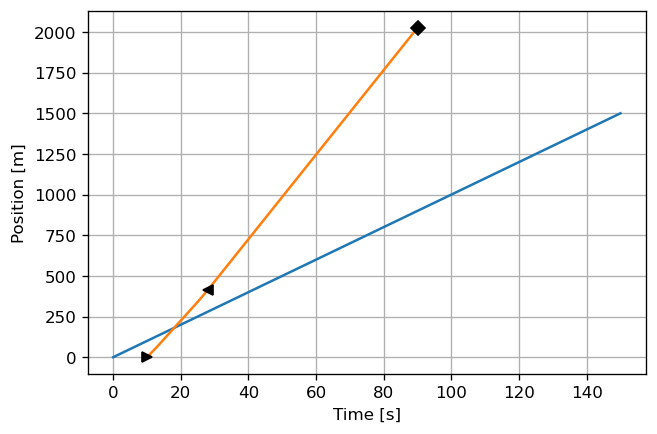

In [123]:
rec.plot('t', 'x')

# Multiple Vehicles with Fixed Speed Profile¶

In [124]:
VMAX = 20
N = 5    #5 vehicles
DT = 7 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)

l = Lane(10000, VMAX)
l.extend(Lane(10000, VMAX))
r = l.widenRight()
for i in range(N):
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=VMAX+3*i, t=[10], v=[VMAX+3*i])
    v.traceOvertake = True
rec.run()

t=    7.0s Overtaking v1 overtakes v0 at x=    0.0m
t=   21.0s Overtaking v3 overtakes v2 at x=    0.0m
t=   66.0s Overtaking v4 overtakes v2 at x=1,128.6m
t=   74.0s Overtaking v1 returns to slow lane at x=1,560.5m
t=  112.0s Overtaking v3 returns to slow lane at x=2,538.7m
t=  193.0s Overtaking v4 returns to slow lane at x=4,988.1m


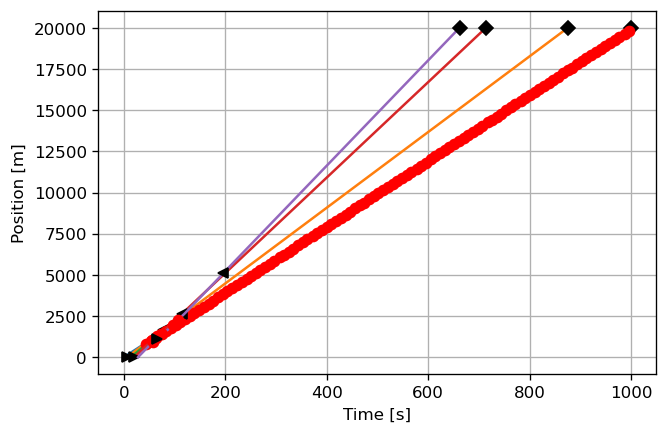

In [125]:
rec.plot('t', 'x')

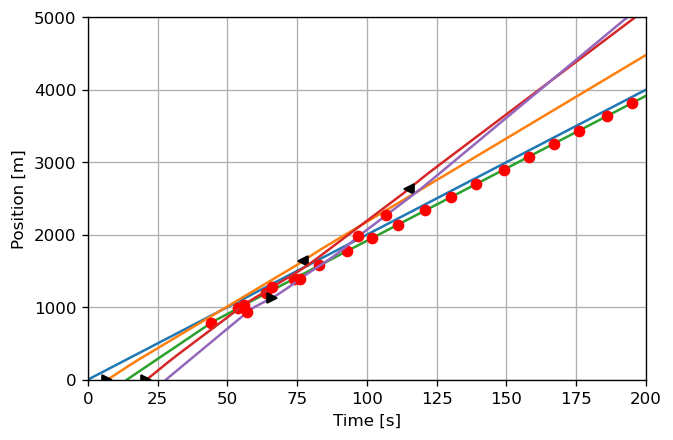

In [126]:
rec.plot('t', 'x', xmin=0, xmax=200, ymin=0, ymax=5000)

In [127]:
VMAX = 30
N = 8
DT = 7 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(1000, VMAX)
l.extend(Lane(1000, VMAX))
r = l.widenRight()
for i in range(N):
    Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=10,
            t=[20, 20, 40, 200], v=[35-2*i, 35-2*i, 15-2*i, 15-2*i])
rec.run()

In [128]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
8,7,0,10,0,1,0,None,0,enter lane
23,14,0,10,0,2,0,None,0,enter lane
45,21,0,10,0,3,0,None,0,enter lane
74,28,0,10,0,4,0,None,0,enter lane
110,35,0,10,0,5,0,None,0,enter lane
117,36,1010,35.0002,-1.11111e-05,0,0,None,1010,leave lane
118,36,1010,35.0002,-1.11111e-05,0,1,None,10,enter lane
155,42,0,10,0,6,0,None,0,enter lane
177,45,1024,33.0002,-1.11111e-05,1,0,None,1024,leave lane


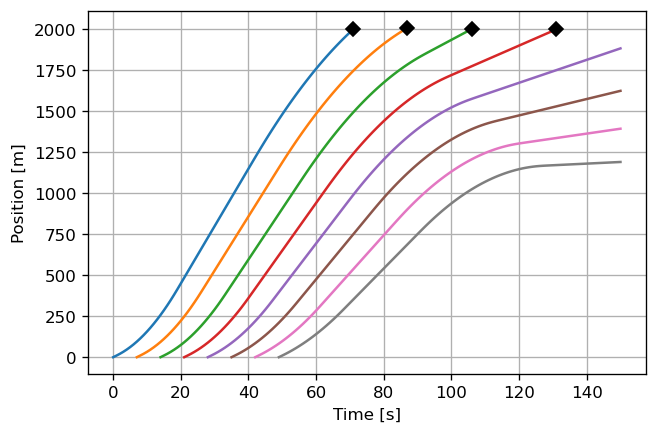

In [129]:
rec.plot('t', 'x')

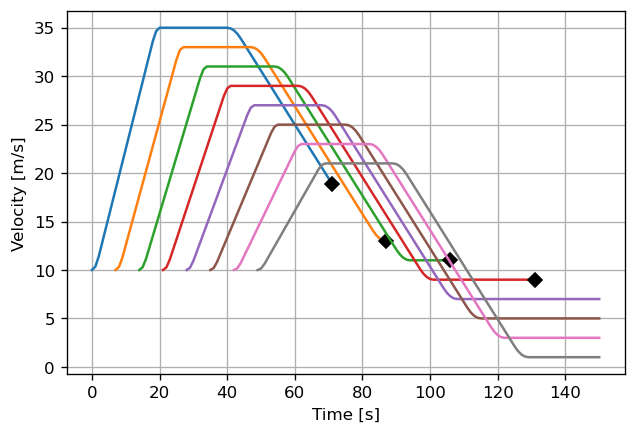

In [130]:
rec.plot('t', 'v')

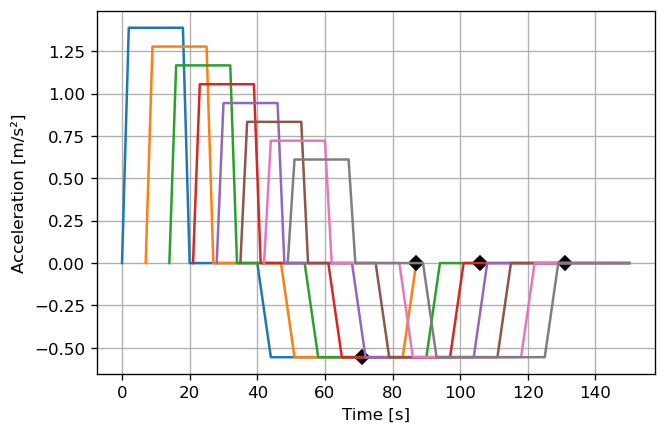

In [72]:
rec.plot('t', 'a')

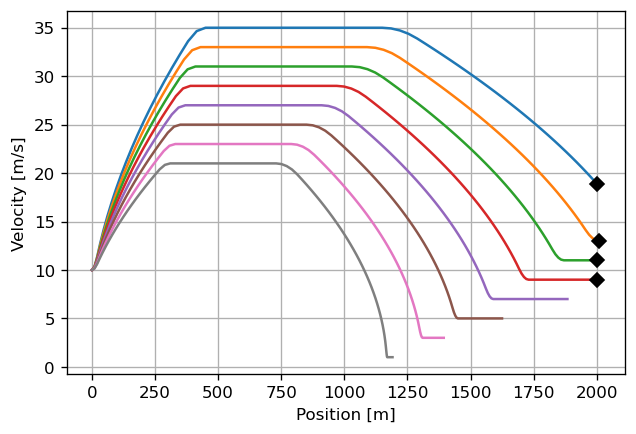

In [73]:
rec.plot('x', 'v')

# Testing Vehicles with Random Speed Profile

In [131]:
SLOW_CYCLE = 100

In [132]:
def randomIntervals(cycles):
    # return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ] 
    return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]

In [133]:
times = randomIntervals(5)
times

[101.89240398223183,
 64.89517718678053,
 108.67765536130176,
 91.1986998762182,
 92.59858344003455]

In [134]:
SPEED_VARIATION = 0.05 #To get an idea about the time intervals and the speed approached we look at the first few random values:

In [135]:
random.seed(13)

In [136]:
def randomSpeedVariation(vmax, cycles, cv=SPEED_VARIATION):
    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ] 

In [137]:
speed = randomSpeedVariation(30, 5)
speed

[31.970316714337258,
 26.85593790908569,
 31.051052581944614,
 28.82819178410906,
 30.692366060170666]

# A Single Vehicle of Varying Speed


In [140]:
CYCLES = 6
VMAX = 120/3.6
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)

l = Lane(5000, VMAX)
while l.totalLength()<40000:
    l.extend(Lane(5000, VMAX))
r = l.widenRight()

times = randomIntervals(CYCLES)
speed = randomSpeedVariation(VMAX, CYCLES)
Vehicle(env, rec, startingLane=l, dx0=speed[-1], t=times, v=speed)
rec.run()

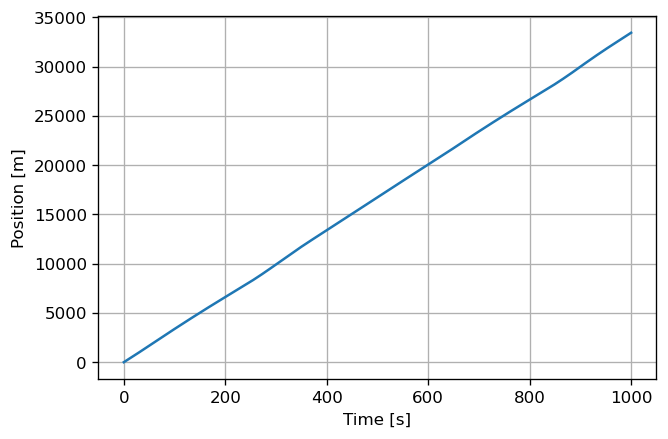

In [141]:
rec.plot('t', 'x')

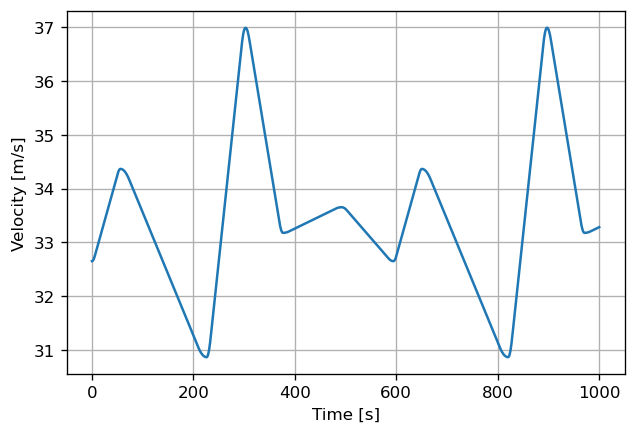

In [142]:
rec.plot('t', 'v')

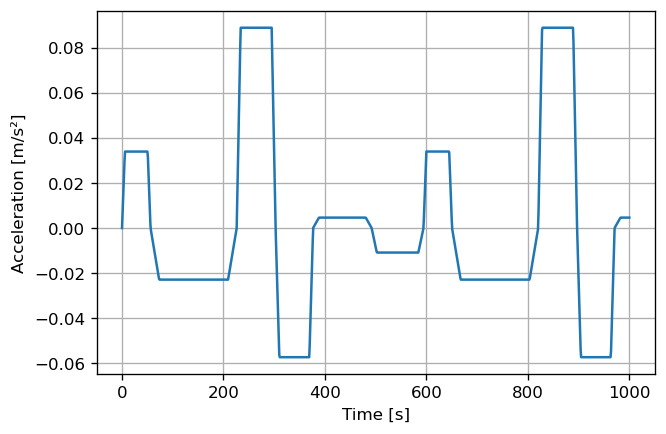

In [143]:
rec.plot('t', 'a')

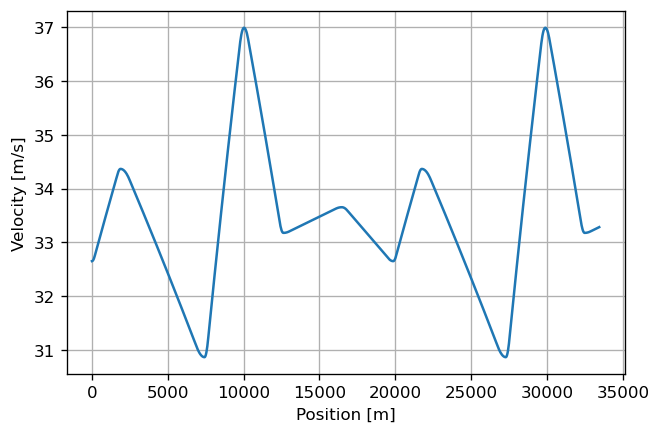

In [144]:
rec.plot('x', 'v')

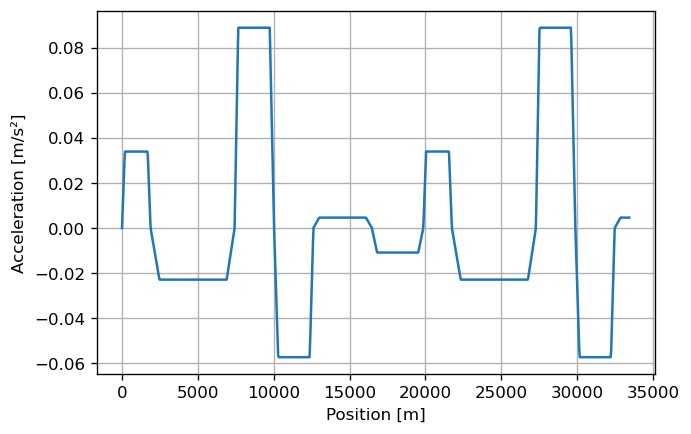

In [145]:
rec.plot('x', 'a')

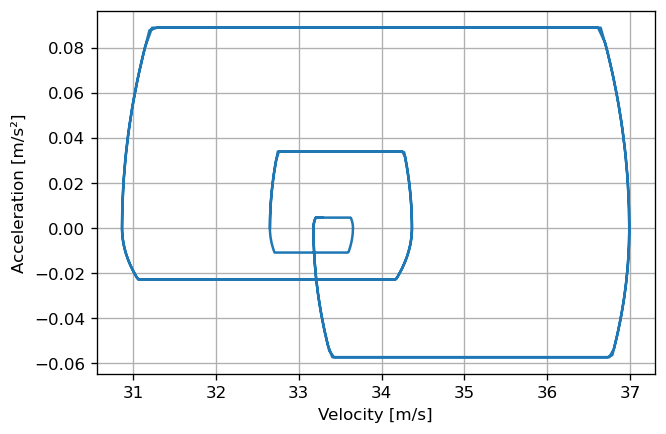

In [146]:
rec.plot('v', 'a')

# Multiple Vehicles with Varying Speeds

In [147]:
VMAX = 120/3.6
N = 5 # number of vehicles
DT = 5 # time difference between start
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 4000, 1)

l = Lane(10000, VMAX)
while l.totalLength()<150000:
    l.extend(Lane(10000, VMAX))
r = l.widenRight()

for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX+i, CYCLES)
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
    
rec.run()

t=   15.0s Overtaking v3 overtakes v2 at x=    0.0m
t=   50.0s Overtaking v2 overtakes v1 at x=1,359.2m
t=  115.0s Overtaking v3 returns to slow lane at x=3,734.2m
t=  227.0s Overtaking v1 overtakes v3 at x=7,439.2m
t=  261.0s Overtaking v2 returns to slow lane at x=8,924.6m
t=  270.0s Overtaking v4 overtakes v3 at x=8,854.4m
t=  305.0s Overtaking v1 returns to slow lane at x=10,263.1m
t=  461.0s Overtaking v4 returns to slow lane at x=15,864.4m
t=  468.0s Overtaking v4 overtakes v2 at x=16,141.3m
t=  482.0s Overtaking v4 returns to slow lane at x=16,713.1m
t=  650.0s Overtaking v4 overtakes v2 at x=22,677.9m
t=  697.0s Overtaking v4 returns to slow lane at x=24,511.7m
t=  963.0s Overtaking v3 overtakes v0 at x=32,027.1m
t=1,016.0s Overtaking v3 returns to slow lane at x=34,044.2m
t=1,175.0s Overtaking v3 overtakes v1 at x=40,154.6m
t=1,221.0s Overtaking v3 returns to slow lane at x=41,987.4m
t=2,301.0s Overtaking v3 overtakes v2 at x=81,399.0m
t=2,401.0s Overtaking v3 returns to slow 

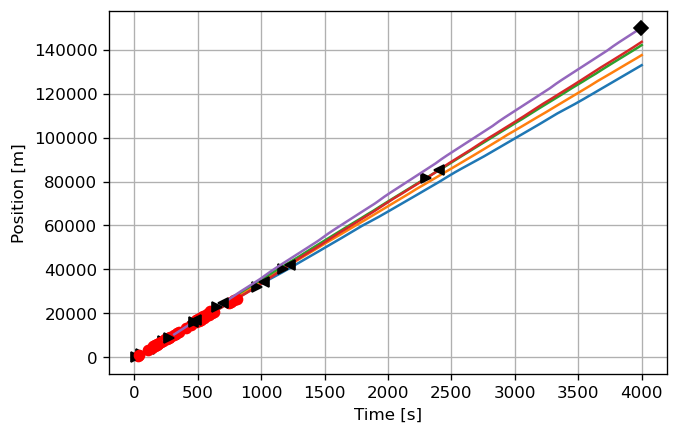

In [148]:
rec.plot('t', 'x')

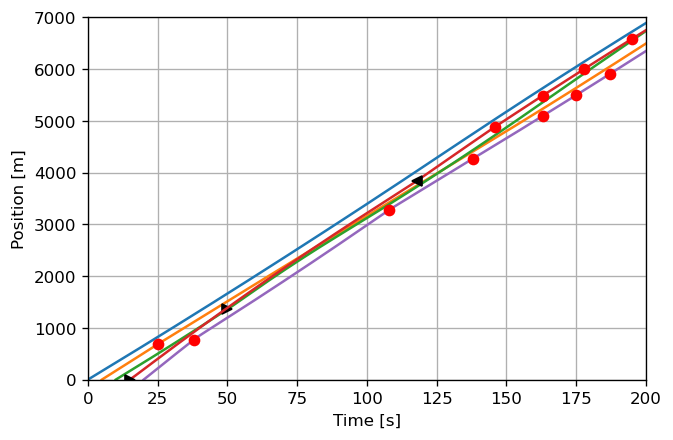

In [149]:
rec.plot('t', 'x', xmin=0, xmax=200, ymin=0, ymax=7000)

In [150]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,32.704421,0,0,0,None,0,enter lane
6,5,0,33.913983,0,1,0,None,0,enter lane
17,10,0,33.014974,0,2,0,None,0,enter lane
33,15,0,37.593668,0,3,0,None,0,enter lane
38,15,0,37.593668,0,3,0,None,0,change fast
...,...,...,...,...,...,...,...,...,...
19774,3914,130002,33.382900,0.0278254,0,13,None,1.67,enter lane
19921,3943,140002,36.222400,0.0575974,2,13,None,10001.6,leave lane
19922,3943,140002,36.222400,0.0575974,2,14,None,1.6,enter lane
20200,3998,150018,37.214800,-0.0175074,4,14,None,10018.1,leave lane


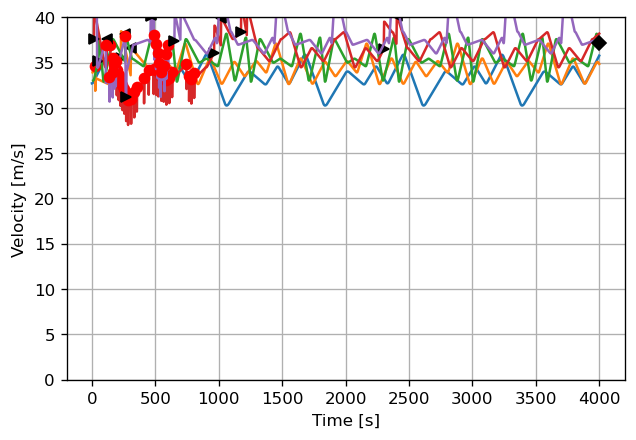

In [152]:
rec.plot('t', 'v', ymin=0, ymax=40)

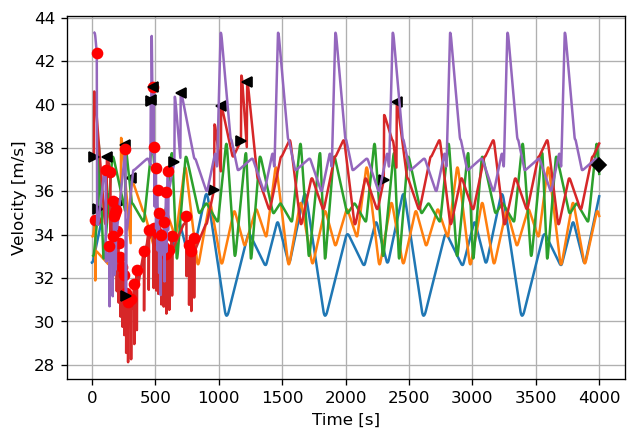

In [100]:
rec.plot('t', 'v')

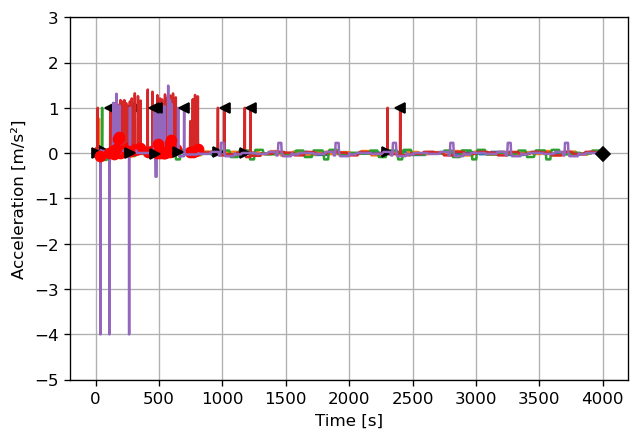

In [101]:
rec.plot('t', 'a', ymin=-5, ymax=3)

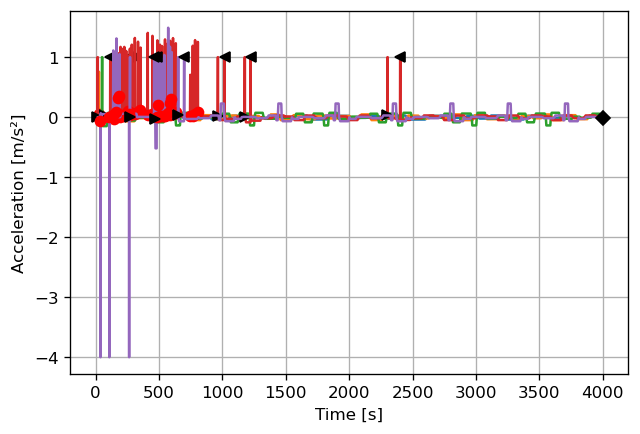

In [102]:
rec.plot('t', 'a')

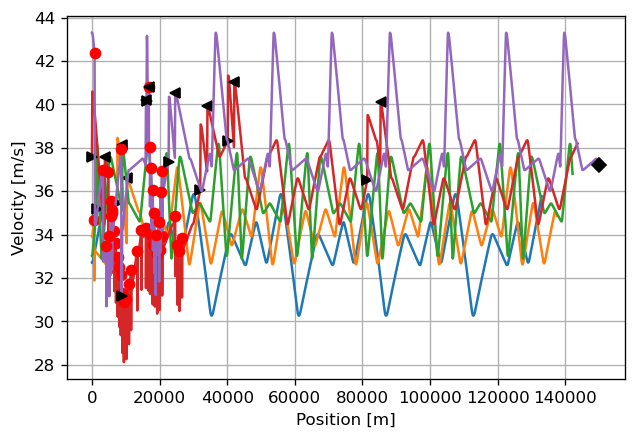

In [103]:
rec.plot('x', 'v')

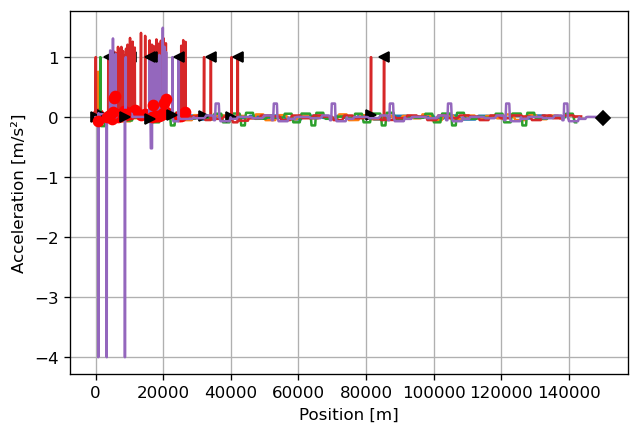

In [104]:
rec.plot('x', 'a')

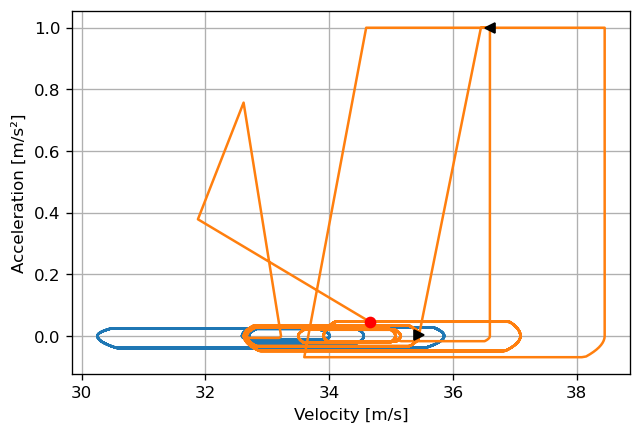

In [105]:
rec.plot('v', 'a', vehicles=[0,1])

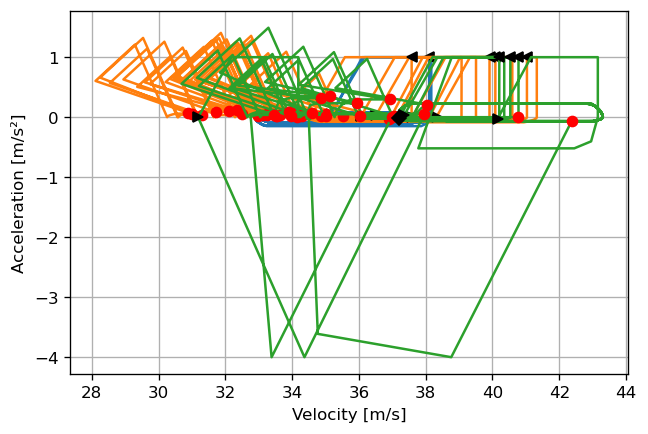

In [106]:
rec.plot('v', 'a', vehicles=[2,3,4])

# Multiple Vehicles with Fixed Speed Profile (Emergency Braking or Overtaking)

Two Vehicles with Not Enough Distance in between

In [153]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(2000, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane = l, t0=0, dx0=10)
Vehicle(env, rec, startingLane = l, t0=20, dx0=20)
rec.run()

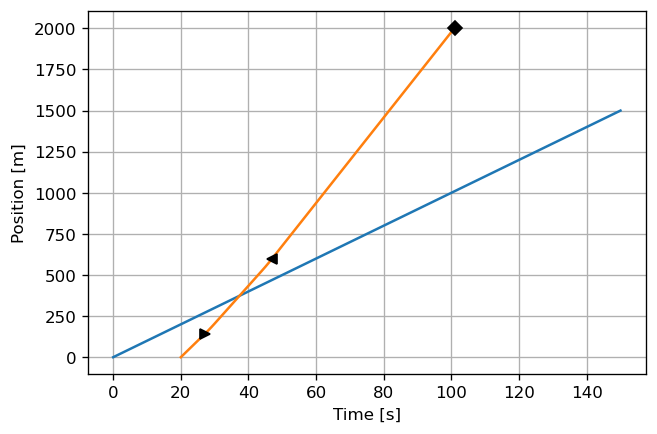

In [154]:
rec.plot('t', 'x')

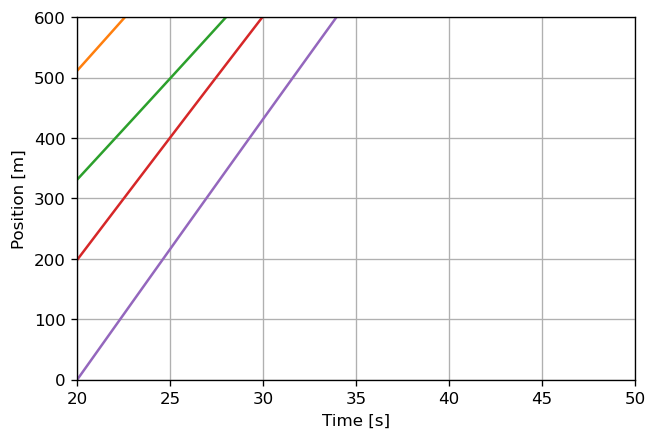

In [108]:
rec.plot('t', 'x', xmin=20, xmax=50, ymin=0, ymax=600)

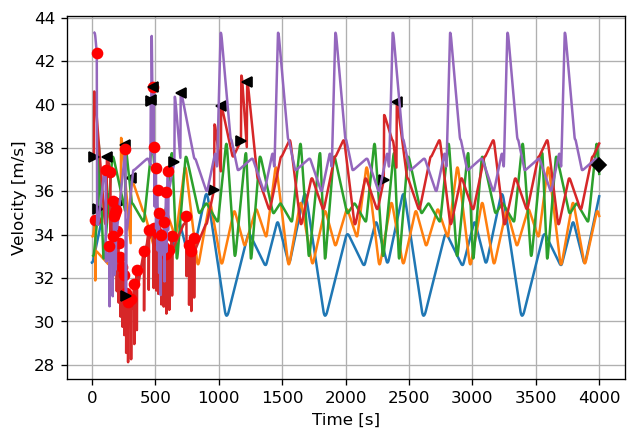

In [109]:
rec.plot('t', 'v')

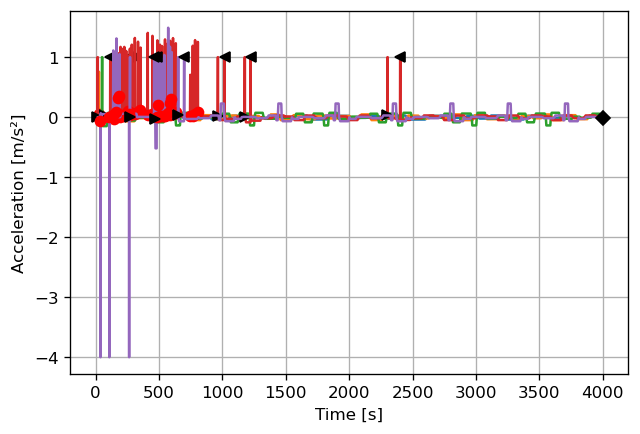

In [110]:
rec.plot('t', 'a')

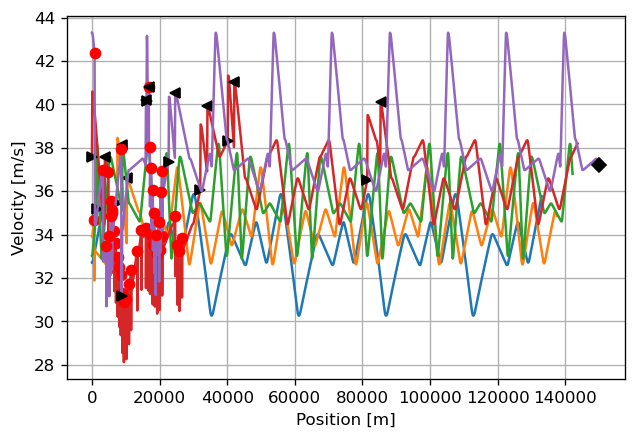

In [111]:
rec.plot('x', 'v')

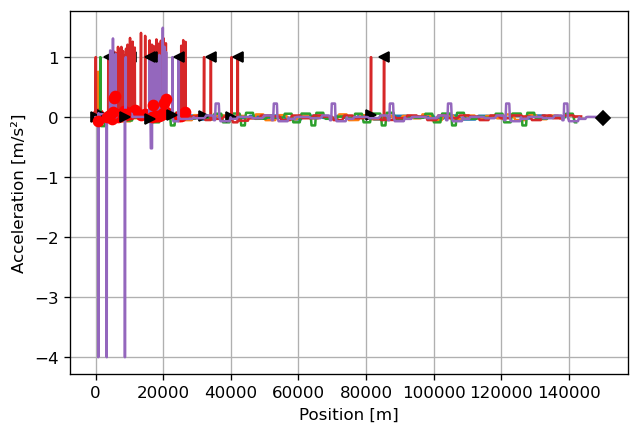

In [112]:
rec.plot('x', 'a')

In [113]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 5)
l = Lane(2000, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=l, t0=10, dx0=20)
rec.run()

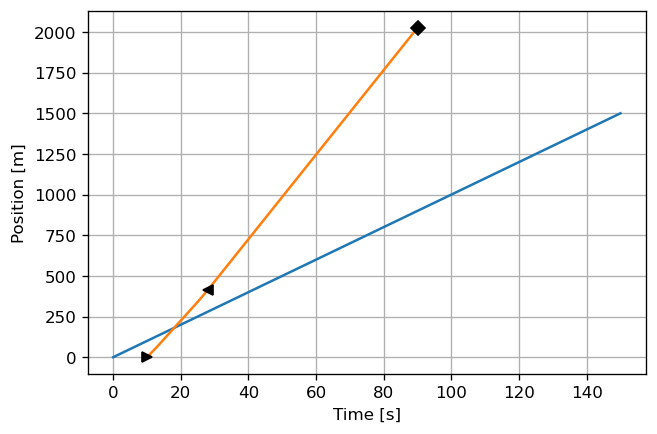

In [114]:
rec.plot('t', 'x')

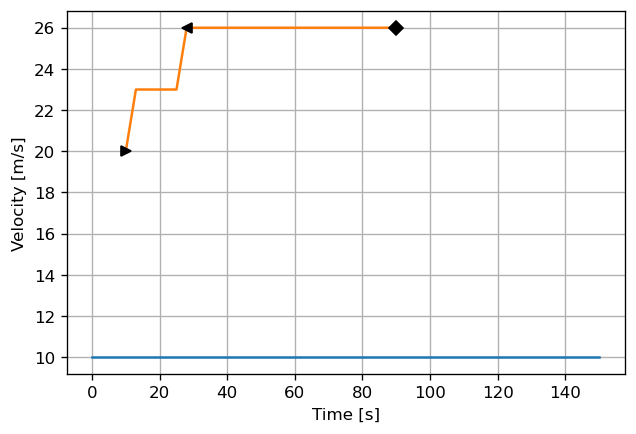

In [115]:
rec.plot('t', 'v')

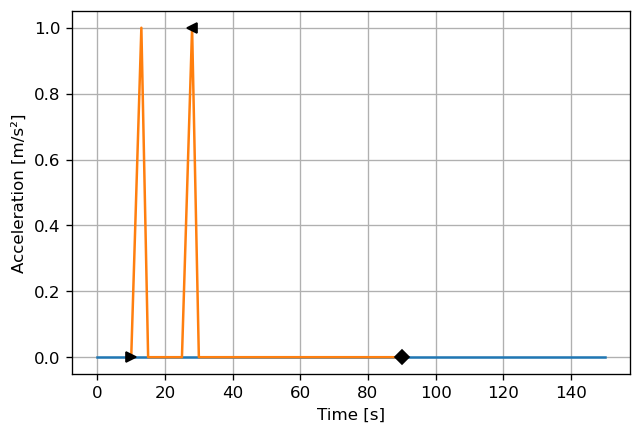

In [116]:
rec.plot('t', 'a')

# Multiple Vehicles with Just Enough Distance in between

In [174]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 5)
l = Lane(2000, VMAX)
r = l.widenRight()

Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=l, t0=10, dx0=15)
Vehicle(env, rec, startingLane=l, t0=20, dx0=20)
Vehicle(env, rec, startingLane=l, t0=30, dx0=25)
rec.run()

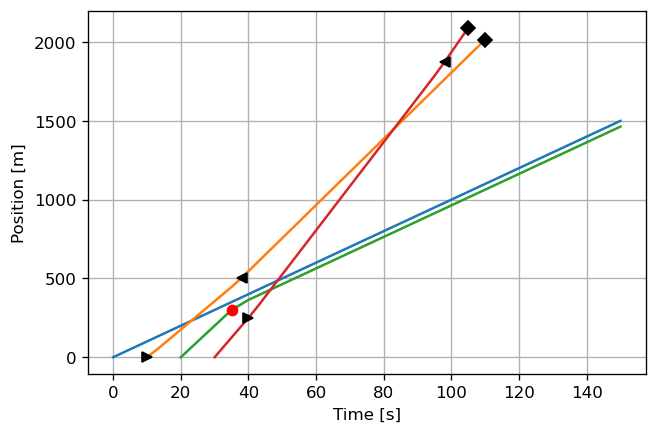

In [175]:
rec.plot('t', 'x')

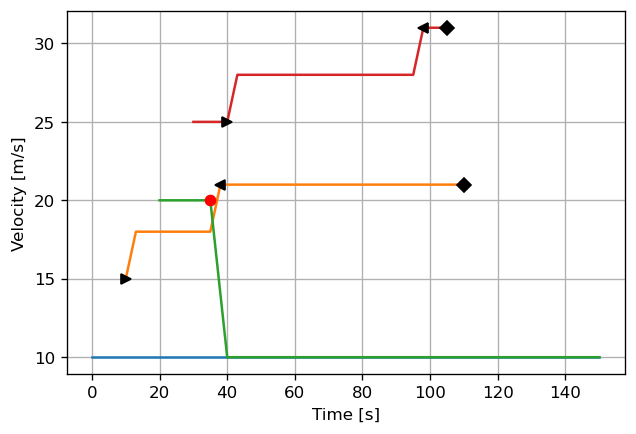

In [157]:
rec.plot('t', 'v')

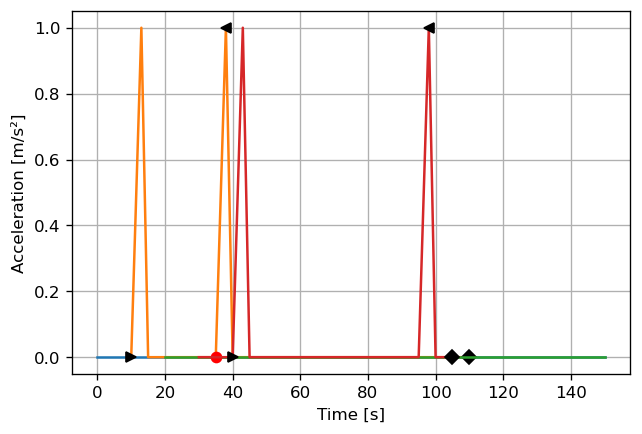

In [158]:
rec.plot('t', 'a')

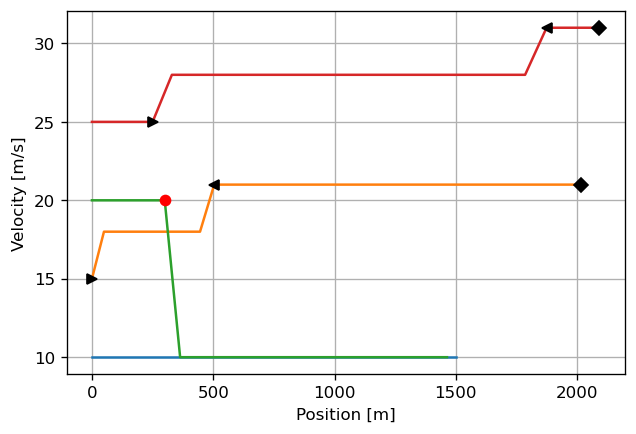

In [159]:
rec.plot('x', 'v')

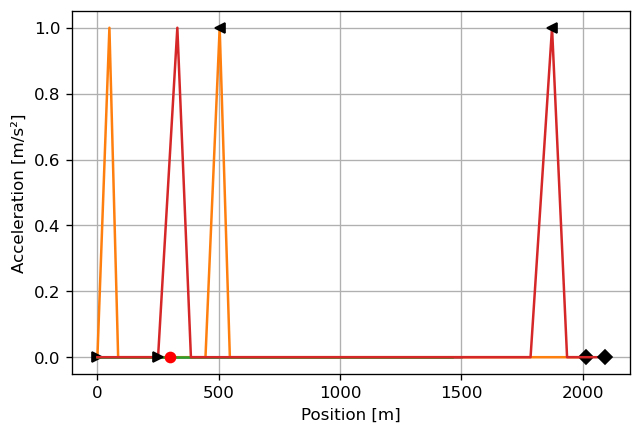

In [160]:
rec.plot('x', 'a')

# A Larger Number of Vehicles with not enough Distance in between

In [161]:
VMAX = 120/3.6
N = 7
DT = 10 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
l = Lane(5000, VMAX)
r = l.widenRight()
for i in range(N):
    Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=10, t=[15, 30, 50], v=[25+2*i, 25+2*i, 15+2*i])
rec.run()

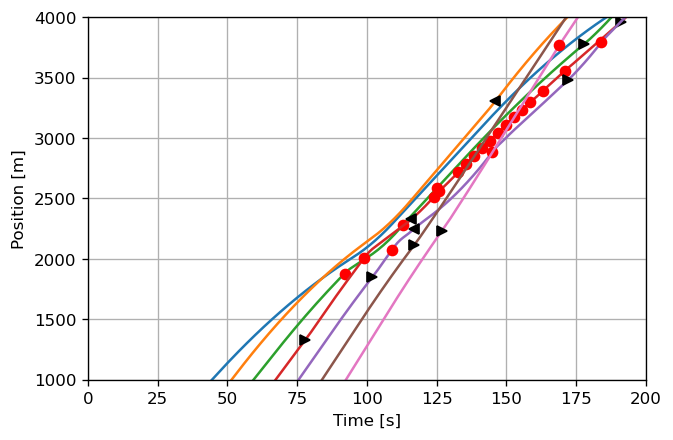

In [162]:
rec.plot('t', 'x', xmin=0, xmax=200, ymin=1000, ymax=4000)

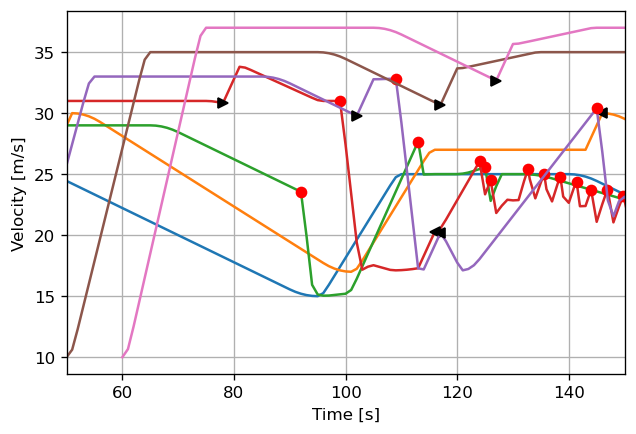

In [163]:
rec.plot('t', 'v', xmin=50, xmax=150)

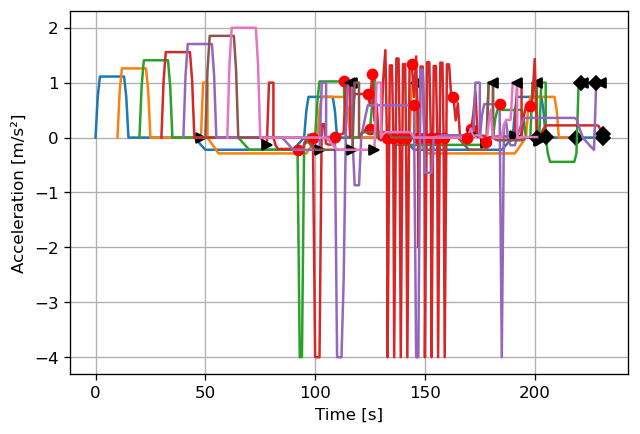

In [164]:
rec.plot('t', 'a')

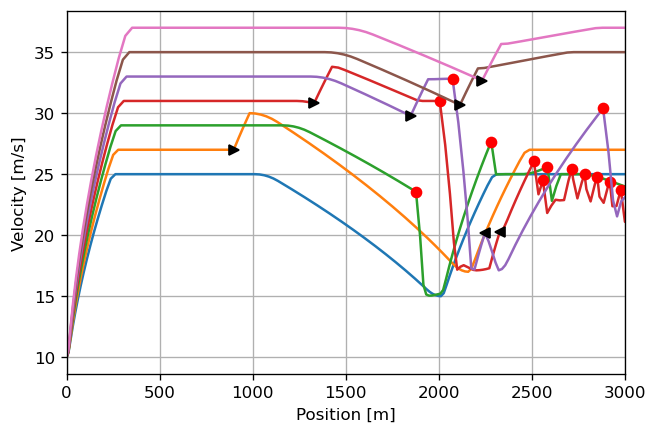

In [165]:
rec.plot('x', 'v', xmin=0, xmax=3000)

# Multiple Vehicles with Fixed Speed Profile (Crash Scenario)

Two Vehicles with Not Enough Distance in between

In [177]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(1000, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=l, t0=5, dx0=30)
rec.run()

Crash p1 into p0 at t=  9.000 x=   89.6


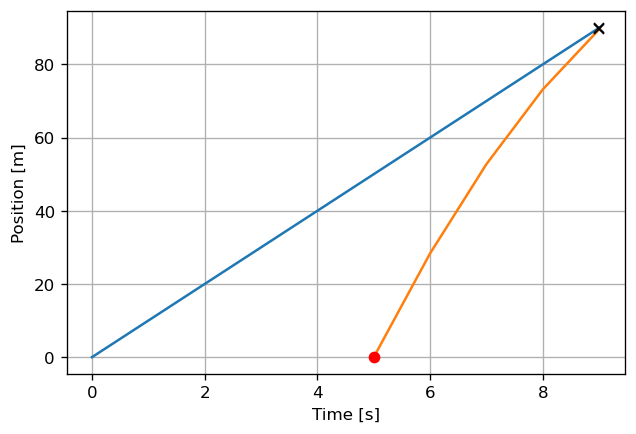

In [178]:
rec.plot('t', 'x')

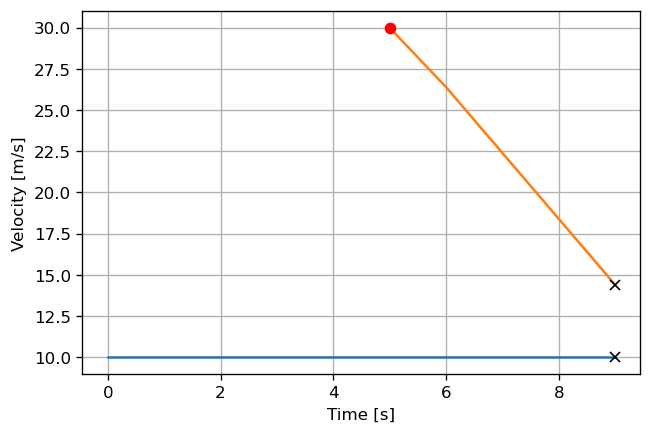

In [179]:
rec.plot('t', 'v')

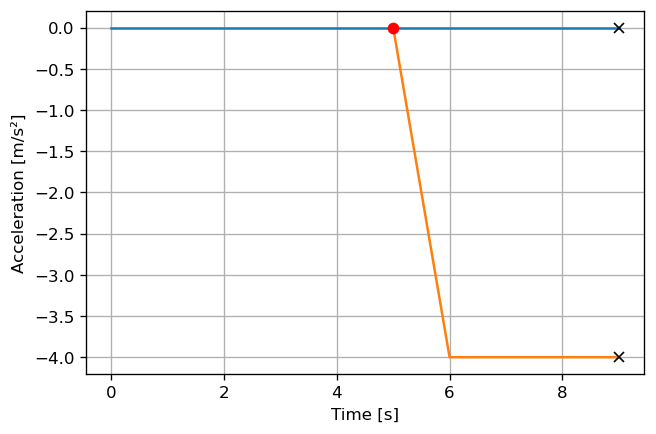

In [180]:
rec.plot('t', 'a')

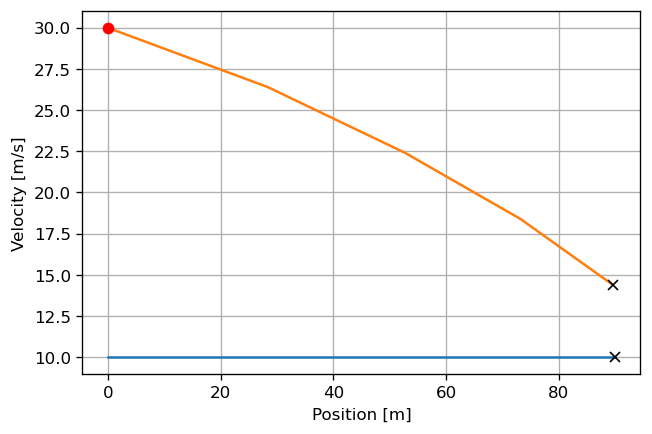

In [181]:
rec.plot('x', 'v')

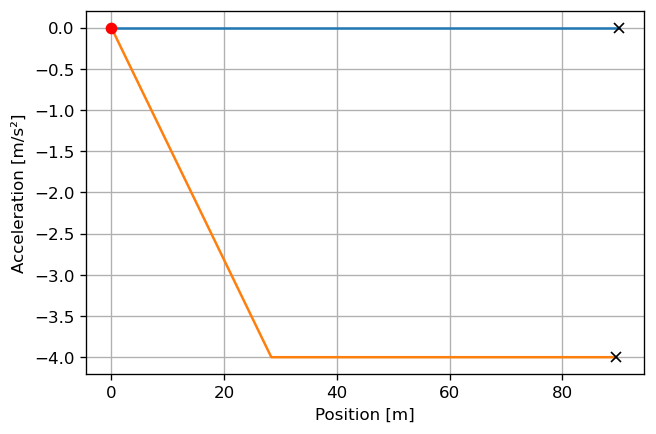

In [182]:
rec.plot('x', 'a')

# Multiple Vehicles with Not Enough Distance in between

In [183]:
VMAX = 120/3.6
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 150, 1)
l = Lane(1500, VMAX)
r = l.widenRight()
Vehicle(env, rec, startingLane=l, t0=0, dx0=10)
Vehicle(env, rec, startingLane=l, t0=6, dx0=18)
Vehicle(env, rec, startingLane=l, t0=15, dx0=40)
Vehicle(env, rec, startingLane=l, t0=25, dx0=16)
rec.run()

Crash p1 into p2 at t= 20.000 x=  148.8


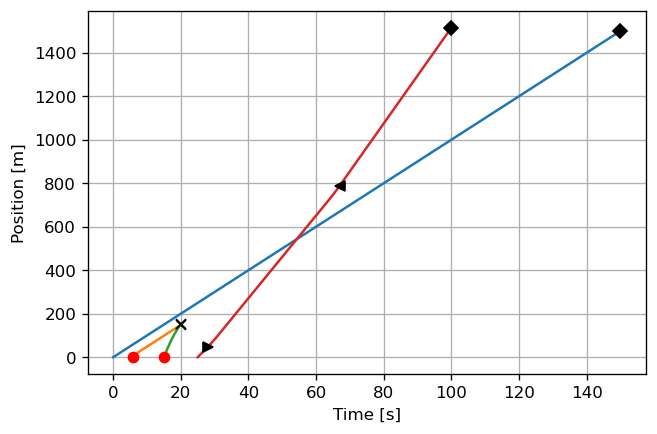

In [184]:
rec.plot('t', 'x')

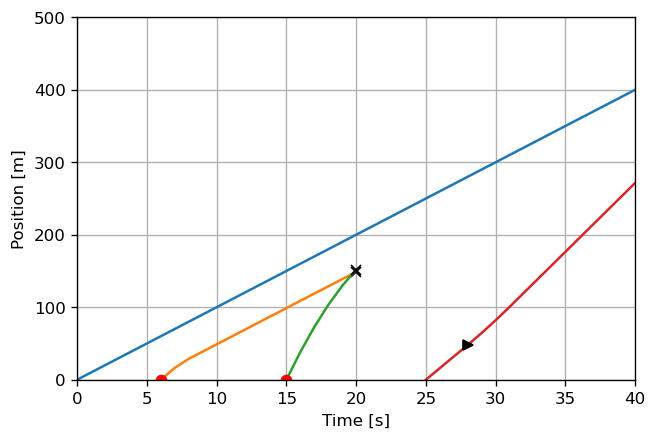

In [185]:
rec.plot('t', 'x', xmin=0, xmax=40, ymin=0, ymax=500)

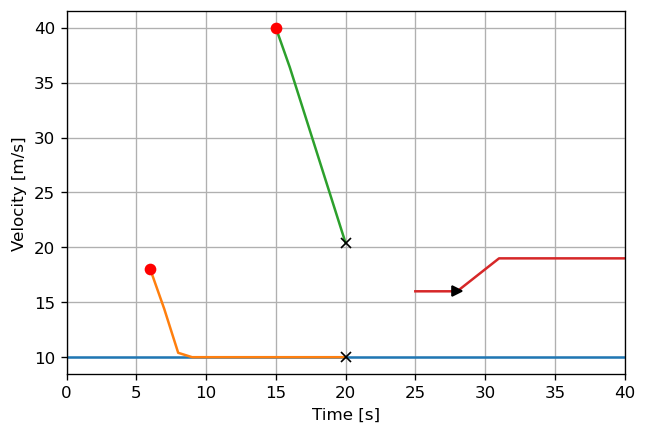

In [186]:
rec.plot('t', 'v', xmin=0, xmax=40)

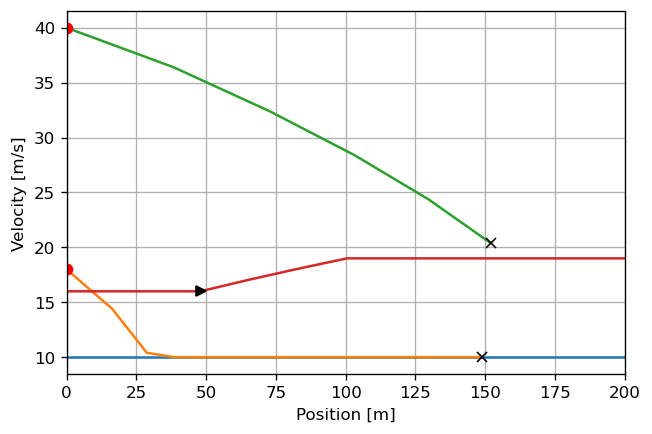

In [187]:
rec.plot('x', 'v', xmin=0, xmax=200)

In [188]:
data = rec.getData()
data[data['event']=='crash']

,t,x,v,a,id,lane,oldLane,pos,event
46,20,148.8,10,0,1,0,None,148.8,crash
47,20,151.97,20.4,-4,2,0,None,151.97,crash


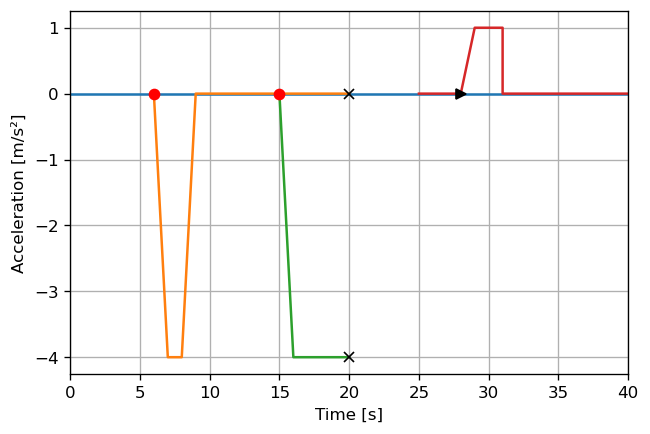

In [189]:
rec.plot('t', 'a', xmin=0, xmax=40)

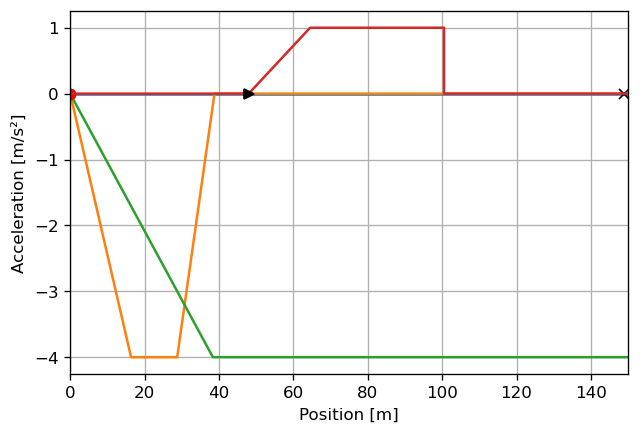

In [190]:
rec.plot('x', 'a', xmin=0, xmax=150)

# Row of Vehicles with Varying Speed

In [249]:
VMAX = 120/3.6
N = 5 # number of points
DT = 10 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
l = Lane(35000, VMAX)### Row of Cars with Varying Speed
r = l.widenRight()
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=VMAX, t=times, v=speed)
rec.run()

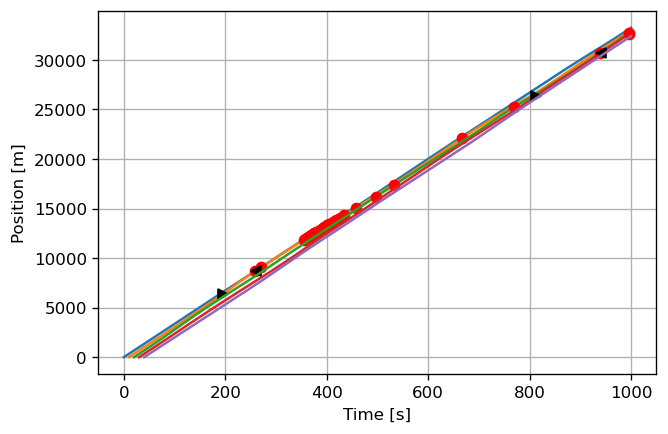

In [250]:
rec.plot('t', 'x')

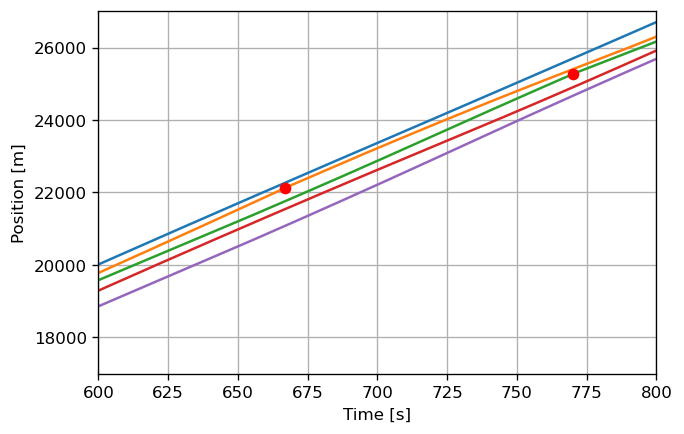

In [251]:
rec.plot('t', 'x', xmin=600, xmax=800, ymin=17000, ymax=27000)

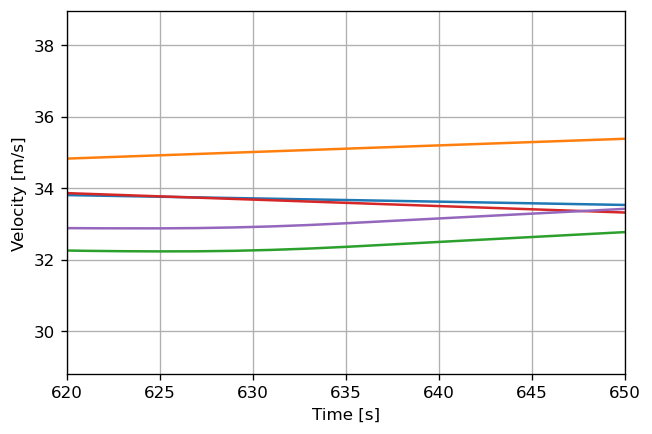

In [252]:
rec.plot('t', 'v', xmin=620, xmax=650)

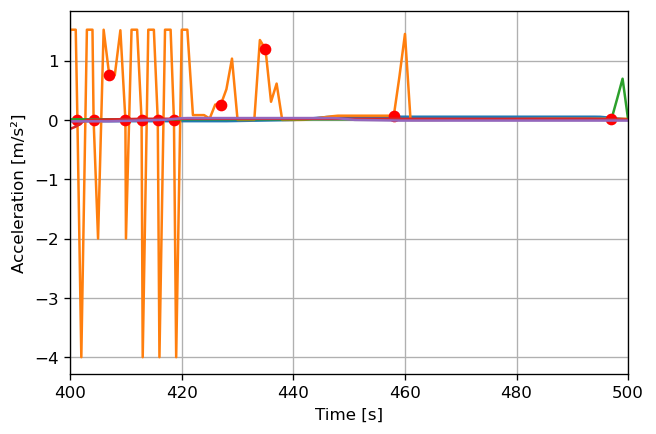

In [253]:
rec.plot('t', 'a', xmin=400, xmax=500)

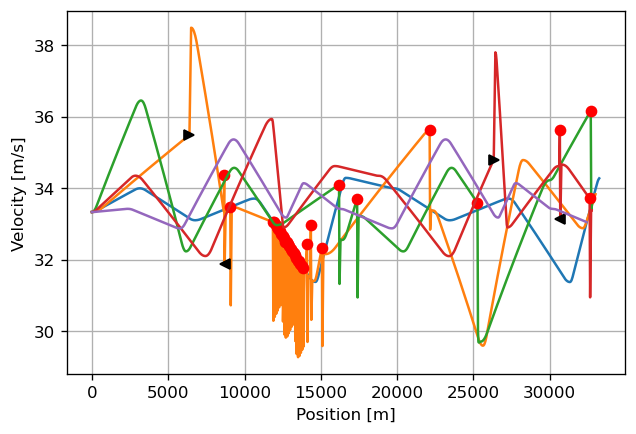

In [254]:
rec.plot('x', 'v')

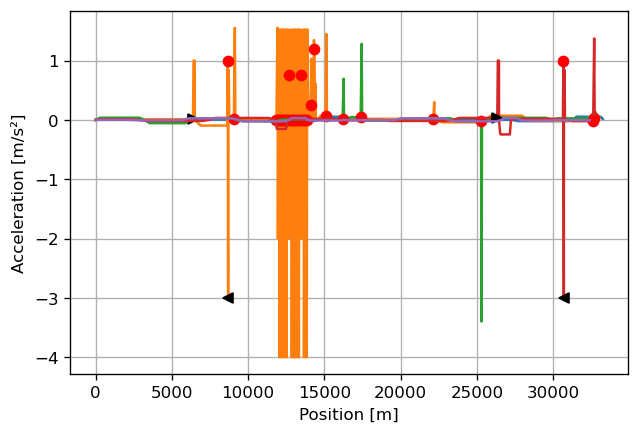

In [255]:
rec.plot('x', 'a')

# Row of Vehicles with Varying Speed and Interarrival Times

In [208]:
VMAX = 120/3.6
N = 5 # number of points 
IAT = 20 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)
iat = [ random.expovariate(1.0/IAT) for i in range(N) ]

l = Lane(1000, VMAX)
while l.totalLength()<70000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()

t0 = 0
for i in range(N):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat[i]
    v = Vehicle(env, rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True
rec.run()

t=  409.0s Overtaking v4 overtakes v3 at x=10,596.4m
t=  709.0s Overtaking v4 returns to slow lane at x=20,826.8m
t=  960.0s Overtaking v3 overtakes v4 at x=29,197.8m


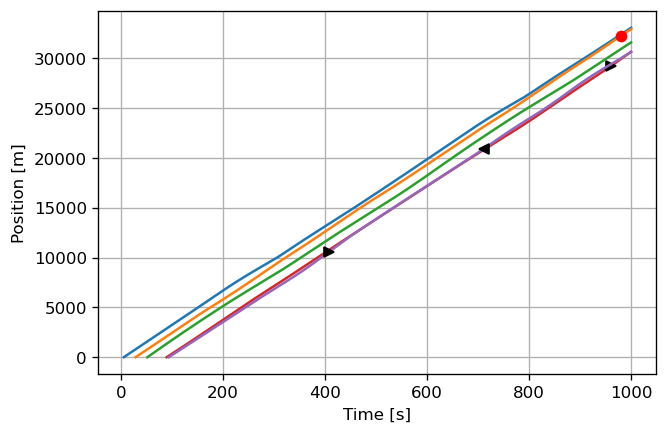

In [209]:
rec.plot('t', 'x')

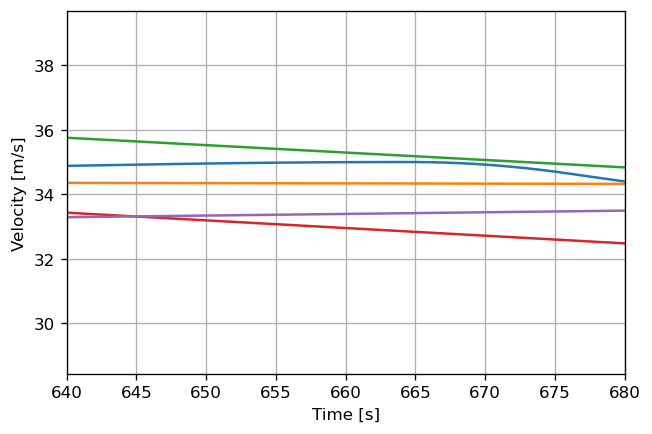

In [210]:
rec.plot('t', 'v', xmin=640, xmax=680)

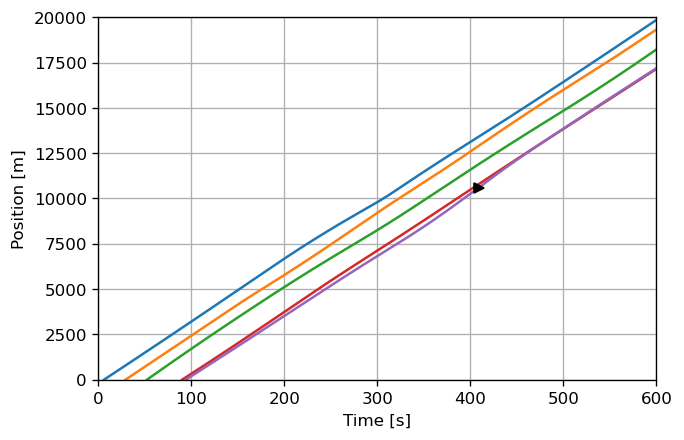

In [211]:
rec.plot('t', 'x', xmin=0, xmax=600, ymin=0, ymax=20000)

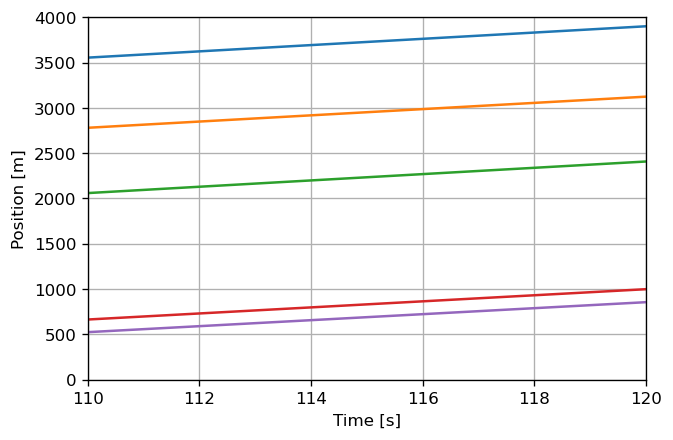

In [212]:
rec.plot('t', 'x', xmin=110, xmax=120, ymin=0, ymax=4000)

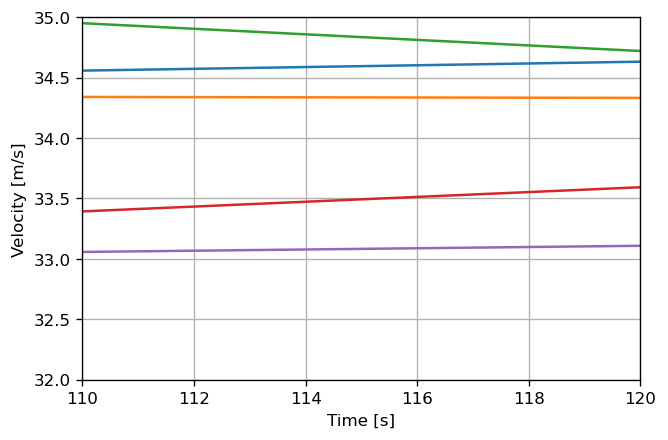

In [213]:
rec.plot('t', 'v', xmin=110, xmax=120, ymin=32, ymax=35)

# Generating Data for Motorway Speed

In [214]:
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.003, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01, 0.003])

def random_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(quantiles)):
        if u<quantiles[i+1]:
            p = (u-quantiles[i])/(quantiles[i+1]-quantiles[i])
            return free_speed[i]*p+free_speed[i+1]*(1-p)

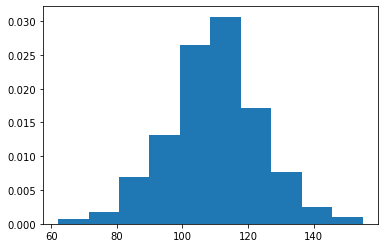

In [215]:
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
hist = plt.hist(speeds, bins=10, density=True)

This simple approach generates however a stepwise distribution function, which may have undesired side effects for large sample sets, as we can see in this example:

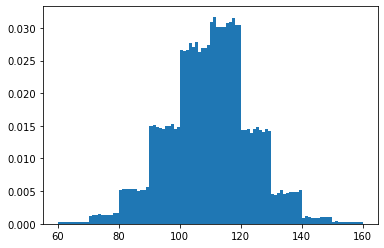

In [216]:
random.seed(0)
speeds = [ random_speed() for i in range(100000)]
hist = plt.hist(speeds, bins=100, density=True)

Based on the reconstructed survey data we generate a gaussian kernel that matches the histogram;

In [217]:
random.seed(0)
speeds = [ random_speed() for i in range(1200)]
kernel = stats.gaussian_kde(speeds)

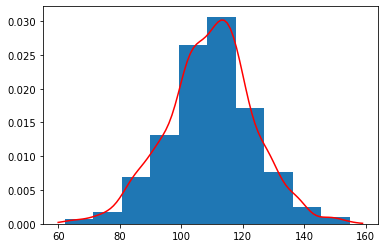

In [218]:
plt.hist(speeds, bins=10, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')

In [219]:
v = np.arange(30, 191)
q = [ kernel.integrate_box_1d(30, i) for i in v ]

def freeMotorwaySpeed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(q)):
        if u<q[i+1]:
            p = (u-q[i])/(q[i+1]-q[i])
            # return (free_speed[i+1]+free_speed[i])/2*p+(1-p)*(free_speed[i+1]+free_speed[i+2])/2
            return v[i]*p+v[i+1]*(1-p)

In [220]:
random.seed(0)
rspeeds = [ freeMotorwaySpeed() for i in range(100000) ]

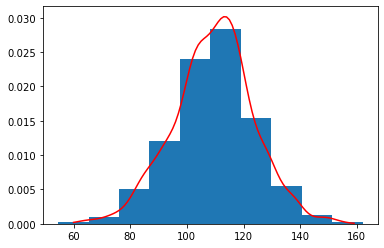

In [221]:
h = plt.hist(rspeeds, bins=10, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')

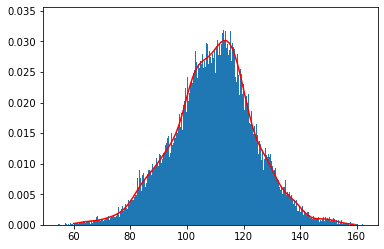

In [222]:
h = plt.hist(rspeeds, bins=1000, density=True)
x = np.arange(60, 160, 1)
y = kernel(x)
plot = plt.plot(x, y, color='red')